In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rawio.IO import *
import uproot 

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
import qetpy as qp

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/astropy/version.py:26: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  for j, piece in enumerate(LooseVersion(version).version[:3]):
/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/astropy/utils/introspection.py:160: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(have_version) >= LooseVersion(version)
/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/dask/compatibility.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PY_VERSION = LooseVersion(".".join(map(str, sys.version_info[:3])))
/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/dask/array/numpy_compat.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging

In [4]:
%matplotlib inline
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.rc('legend', fontsize=15)

## Read in RQs

In [5]:
series = '23240121_011940' 

In [6]:
filepath = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged/'
noisefilepath = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Noise/'

channames=['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1', 'PAS2','PBS2','PCS2', 'PDS2', 'PES2', 'PFS2']
file = uproot.open(filepath+'Prompt_V04-15_P0.2.1_'+series+'.root')
noisefile = uproot.open(noisefilepath+'Prompt_V04-15_P0.2.1_Filter_'+series+'.root')

In [7]:
EventNumber = file['rqDir/eventTree/EventNumber'].array(library='np')
TriggerType = file['rqDir/eventTree/TriggerType'].array(library='np')
TriggerDetector = file['rqDir/eventTree/TriggerDetectorNum'].array(library='np')

# Fetching RQs for Dectector 2 
RQs_zip2 = file.get('rqDir/zip2')

empties = RQs_zip2['Empty'].array(library='np') # tells which events are empty

OFamps = {}
OFchisq = {}
OFdelays = {}
for chan in np.append(channames, 'PT'):
    OFamps[chan] = RQs_zip2 [chan+'OFamps'].array(library='np')
    OFchisq[chan] = RQs_zip2 [chan+'OFchisq'].array(library='np')
    OFdelays[chan] = RQs_zip2[chan+'OFdelay'].array(library='np')
    

zip2_noise = noisefile.get('zip2')
templates = {}
freq = {}
psd ={}
for chan in np.append(channames, 'PT'):
    templates[chan] = zip2_noise [chan+'TemplateTime;1'].to_numpy()[0]
    freq[chan] = zip2_noise [chan+'NoiseFFT;1'].to_numpy()[1] # NoiseFFT gives unfolded PSD which is required by the OptimumFilter class
    psd[chan] = zip2_noise [chan+'NoiseFFT;1'].to_numpy()[0]


## Plot Template

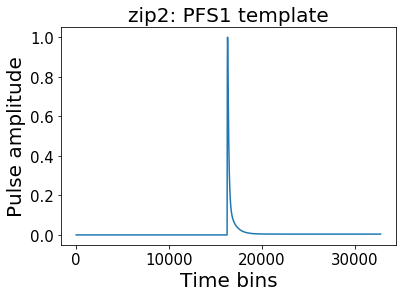

In [8]:
plt.plot(templates['PFS1'])
plt.ylabel('Pulse amplitude')
plt.xlabel('Time bins')
plt.title('zip2: PFS1 template')
plt.show()

## Plot PSD

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-9-6e3a6cf60718>:2: DeprecationWarning: invalid escape sequence \s
  plt.ylabel('A /$\sqrt{(Hz)}$')


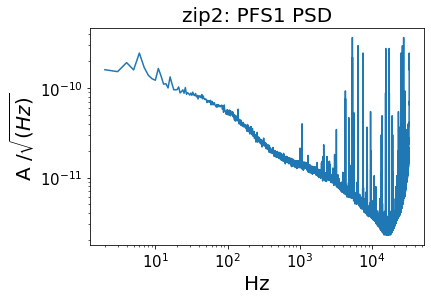

In [9]:
plt.loglog(freq['PFS1'][2:], psd['PFS1'][1:])
plt.ylabel('A /$\sqrt{(Hz)}$')
plt.xlabel('Hz')
plt.title('zip2: PFS1 PSD')
plt.show()

## Conversion between ADC Units and Amperes

In [10]:
fs = 6.25e5 # sampling frequency [Hz]

drivergain = np.unique(file['detectorConfigDir/detectorConfigZip2/PAS1driverGain'].array(library='np'))[0]
ADCperVolt = np.unique(file['infoDir/userSettingsTree/P_DigitizerBinsPerVolt'].array(library='np'))[0]
FB_gain = np.unique(file['infoDir/userSettingsTree/P_FBgain'].array(library='np'))[0]
loop_gain = np.unique(file['infoDir/userSettingsTree/P_LPGain'].array(library='np'))[0]

scale = 1/(drivergain * ADCperVolt * FB_gain *  loop_gain)

## Read in Raw Traces

In [11]:
%%time
filepath_raw = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Raw/'

cut = (OFamps['PT']*1e6>30)&(TriggerDetector==2) 
cut_empty =  (empties == 0) #cut out empty events

samplesize = 500

evt_num = list(EventNumber[cut_empty].astype(int))[:samplesize]
evt_num_cut = list(EventNumber[cut].astype(int))[:samplesize]

traces = getRawEvents(filepath_raw,series,outputFormat=2,eventNumbers=evt_num, skipEmptyEvents=False)
traces_cut = getRawEvents(filepath_raw,series,outputFormat=2,eventNumbers=evt_num_cut)

CPU times: user 26.8 s, sys: 736 ms, total: 27.6 s
Wall time: 28.3 s


In [12]:
traces_channelwise = {}
traces_cut_channelwise = {}
    
for chan in channames:
    
    traces_channelwise[chan] = np.zeros((samplesize, len(traces[0]['Z2']['PAS1'])))
    traces_cut_channelwise[chan] = np.zeros((samplesize, len(traces[0]['Z2']['PAS1'])))
    
    for i, event in enumerate(evt_num):
        
       
        traces_channelwise[chan][i] = traces[i]['Z2'][chan]
        traces_cut_channelwise[chan][i] = traces_cut[i]['Z2'][chan]
        
        traces_channelwise[chan][i] -= np.mean(traces[i]['Z2'][chan][:10000])             #  subtract 
        traces_cut_channelwise[chan][i] -= np.mean(traces_cut[i]['Z2'][chan][:10000])      #  baseline offset
        
        traces_channelwise[chan][i] *= scale          #  convert from ADC Units 
        traces_cut_channelwise[chan][i] *= scale      #                         to Amperes



In [13]:
traces_channelwise['PAS1'][0].shape[0]

32768

In [14]:
getDetectorSettings(filepath_raw,series)['Z2']['PFS1']['timePerBin']**(-1) == fs

True

In [15]:
getDetectorSettings(filepath_raw,series)

{'Z2': {'PFS1': {'Tower': 3.0,
   'binsPerTrace': 32768.0,
   'binsPerTraceOn': 32768.0,
   'binsPerTracePost': 0.0,
   'binsPerTracePre': 0.0,
   'downSamplingFactor': 16.0,
   'driverGain': 8.0,
   'isEnabled': 1.0,
   'ishybrid': 0.0,
   'phononOffset': -0.11755199730396271,
   'qetBias': 6.206719970703125e-05,
   'squidBias': 1.7001989364624022e-05,
   'squidLockPoint': 0.0021200549602508546,
   'timePerBin': 1.6e-06,
   'timePerBinLow': 2.56e-05,
   'triggerTime': 0.026,
   'variableGain': -4.960629940032959,
   'channelNum': 0,
   'pNum': 0,
   'detectorCode': 711002000},
  'PCS1': {'Tower': 3.0,
   'binsPerTrace': 32768.0,
   'binsPerTraceOn': 32768.0,
   'binsPerTracePost': 0.0,
   'binsPerTracePre': 0.0,
   'downSamplingFactor': 16.0,
   'driverGain': 8.0,
   'isEnabled': 1.0,
   'ishybrid': 0.0,
   'phononOffset': -0.09073139727115631,
   'qetBias': 4.781684875488281e-05,
   'squidBias': 1.5999380111694335e-05,
   'squidLockPoint': 0.0020892069339752198,
   'timePerBin': 1.6e

## Play around with PSD

In [16]:
freq1, psd1 = qp.calc_psd(traces_channelwise['PAS1'], fs=fs)
freq1_cut, psd1_cut = qp.calc_psd(traces_cut_channelwise['PAS1'], fs=fs)

In [17]:
autocut = qp.autocuts(traces_channelwise['PAS1'], fs=fs)
autocut_cut = qp.autocuts(traces_cut_channelwise['PAS1'], fs=fs)

In [18]:
freq1_autocut, psd1_autocut = qp.calc_psd(traces_channelwise['PAS1'][autocut], fs=fs)
freq1_cut_autocut, psd1_cut_autocut = qp.calc_psd(traces_cut_channelwise['PAS1'][autocut_cut], fs=fs)

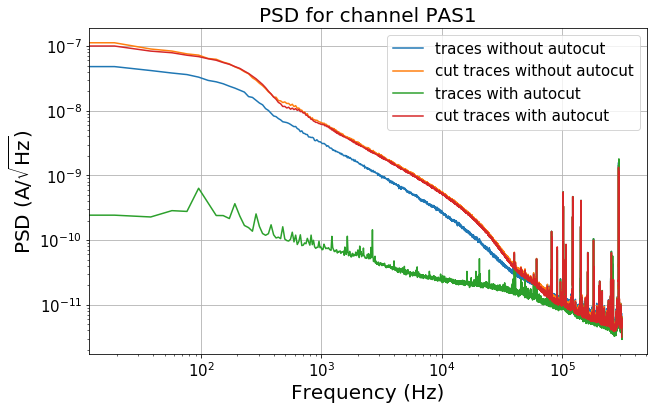

In [19]:
plt.figure(figsize=(10,6))
plt.loglog(freq1,np.sqrt(psd1), label='traces without autocut')
plt.loglog(freq1_cut,np.sqrt(psd1_cut), label='cut traces without autocut')
plt.loglog(freq1_autocut,np.sqrt(psd1_autocut), label='traces with autocut')
plt.loglog(freq1_cut_autocut,np.sqrt(psd1_cut_autocut), label='cut traces with autocut')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
plt.title('PSD for channel PAS1')
plt.show()

Best to use uncut traces for PSD which have a lot of random noise events themselves.

Should use cut traces for OF fotting though since noise traces can have bad OFamp:

Text(0.5, 1.0, 'OFamp: 0.0009165722164789185')

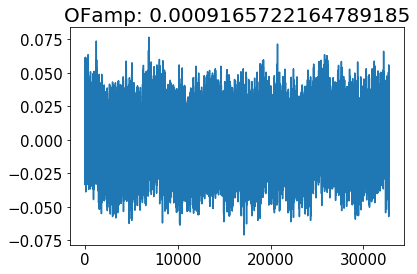

In [20]:
c = 'PAS1'
sample = 20
plt.plot(traces_channelwise[c][sample]*1e6)
plt.title(f'OFamp: {OFamps[c][:samplesize][sample]*1e6}')

## Functions to calculate OFamps via QETpy and compare it to RQs

In [21]:
def compare_QETpy_RQs(template_dict, psd_dict, traces_dict): # template and psd are channelwise!
    
    '''
    Function to calculate OFamps via QETpy and compare it to RQs
    
    Takes the Templates and PSD channelwise
    
    Returns channelwise dictionaries that contain 
        1) The OF Amplitudes
        2) The OF Time delays (shift on the x-axis)
        3) The OF Chisquares
    
    '''
    
    OFqet, OFrq = {}, {}
    for chan in channames:
        
        # calculate OF via QETpy
        # trace in Amperes, psd in A^2/Hz
        # fit to cut traces
        OF = np.array([qp.OptimumFilter(tr, template_dict[chan], psd_dict[chan]**2, fs) for tr in traces_dict[chan]]) 
        OFqet[chan] = np.array( [ of.ofamp_withdelay() for of in OF ] )
        
        # for sake of clarity store OFamps, delays and chisquares from RQs in same structure as OFqet
        OFrq[chan] = np.array( [OFamps[chan][cut][:samplesize], 
                                OFdelays[chan][cut][:samplesize], 
                                OFchisq[chan][cut][:samplesize]] ).T
    
    return OFqet, OFrq
    


In [22]:
OFqet1, OFrq = compare_QETpy_RQs(templates, psd, traces_cut_channelwise)

In [23]:
def plot_comparison(qet_dict, rq_dict, method_temp, method_psd, quantity='amp'):
    
    '''
    Function to scatterplot the values obtained by QETpy against those from the RQs 
    and quantifiy the differences as a histogram
    
    Takes dictionaries in the form returned by compare_QETpy_RQs
    
    '''
    
    # choose which quantity to plot
    index = 0
    xlabel_scatter, ylabel_scatter, xlabel_hist = '', '', ''
    factor = 1
    if quantity == 'amp':
        index = 0
        xlabel_scatter = 'Amp$_{RQ}$ [µA]'
        ylabel_scatter = 'Amp$_{QET}$ [µA]'
        xlabel_hist = 'Amp$_{QET}$ - Amp$_{RQ}$ [µA]'
        factor = 1e6
    elif quantity == 't0':
        index = 1
        xlabel_scatter = 't0$_{RQ}$ [ms]'
        ylabel_scatter = 't0$_{QET}$ [ms]'
        xlabel_hist = 't0$_{QET}$ - t0$_{RQ}$ [ms]'
        factor = 1e3
    elif quantity == 'chi2':
        index = 2
        xlabel_scatter = '$\chi^2_{RQ}$'
        ylabel_scatter = '$\chi^2_{QET}$'
        xlabel_hist = '$\chi^2_{QET}$ - $\chi^2_{RQ}$'
    else:
        print('Please specify one of the following quantities to compare: amp, t0, chi2.')
        return
    
    
    plt.figure(figsize=(25,15))
    
    diff = {}
    mini, maxi = 0,0 # to determine reference linspace
    
    #----------------------------------Side 1--------------------------------------------
    for chan in channames[:6]:
        
        diff[chan] = (qet_dict[chan]-rq_dict[chan])[:,index] # differences only of desired quantity
        
        # update min and max for reference linspace
        if np.min(rq_dict[chan][:,index]) < mini:
            mini = np.min(rq_dict[chan][:,index])
        if np.max(rq_dict[chan][:,index]) > maxi:
            maxi = np.max(rq_dict[chan][:,index])
       #print(mini,maxi)
        
        plt.subplot(2,2,1)
        plt.scatter(rq_dict[chan][:,index]*factor, qet_dict[chan][:,index]*factor, label=chan, s=10)
        
        plt.subplot(2,2,2)
        plt.hist(diff[chan]*factor, bins=20, histtype='step', label=chan)
        
    ref = np.linspace(mini*factor,maxi*factor,100)
    plt.subplot(2,2,1)
    plt.plot(ref,ref,linestyle="dotted",color='black')
    plt.legend()
    plt.grid()
    plt.xlabel(xlabel_scatter)
    plt.ylabel(ylabel_scatter)
    plt.title('Template: ' + method_temp + ', PSD: ' + method_psd + '; Side 1')
    
    plt.subplot(2,2,2)
    plt.legend()
    plt.grid()
    plt.xlabel(xlabel_hist)
    plt.ylabel('Counts')
    plt.title('Template: ' + method_temp + ', PSD: ' + method_psd + '; Side 1')
    
    
    #----------------------------------Side 2--------------------------------------------
    for chan in channames[6:]:
        
        diff[chan] = (qet_dict[chan]-rq_dict[chan])[:,index] # differences only of desired quantity
        
        # update min and max for reference linspace
        if np.min(rq_dict[chan][:,index]) < mini:
            mini = np.min(rq_dict[chan][:,index])
        if np.max(rq_dict[chan][:,index]) > maxi:
            maxi = np.max(rq_dict[chan][:,index])
        
        plt.subplot(2,2,3)
        plt.scatter(rq_dict[chan][:,index]*factor, qet_dict[chan][:,index]*factor, label=chan, s=10)
        
        plt.subplot(2,2,4)
        plt.hist(diff[chan]*factor, bins=20, histtype='step', label=chan)
     
    ref = np.linspace(mini*factor,maxi*factor,100)
    plt.subplot(2,2,3)
    plt.plot(ref,ref,linestyle="dotted",color='black')
    plt.legend()
    plt.grid()
    plt.xlabel(xlabel_scatter)
    plt.ylabel(ylabel_scatter)
    plt.title('Template: ' + method_temp + ', PSD: ' + method_psd + '; Side 2')
    
    plt.subplot(2,2,4)
    plt.legend()
    plt.grid()
    plt.xlabel(xlabel_hist)
    plt.ylabel('Counts')
    plt.title('Template: ' + method_temp + ', PSD: ' + method_psd + '; Side 2')
    
    plt.tight_layout()
        
    
    
    return diff
        

<>:29: DeprecationWarning: invalid escape sequence \c
<>:30: DeprecationWarning: invalid escape sequence \c
<>:31: DeprecationWarning: invalid escape sequence \c
<>:29: DeprecationWarning: invalid escape sequence \c
<>:30: DeprecationWarning: invalid escape sequence \c
<>:31: DeprecationWarning: invalid escape sequence \c
<>:29: DeprecationWarning: invalid escape sequence \c
<>:30: DeprecationWarning: invalid escape sequence \c
<>:31: DeprecationWarning: invalid escape sequence \c
<ipython-input-23-52dfa9921177>:29: DeprecationWarning: invalid escape sequence \c
  xlabel_scatter = '$\chi^2_{RQ}$'
<ipython-input-23-52dfa9921177>:30: DeprecationWarning: invalid escape sequence \c
  ylabel_scatter = '$\chi^2_{QET}$'
<ipython-input-23-52dfa9921177>:31: DeprecationWarning: invalid escape sequence \c
  xlabel_hist = '$\chi^2_{QET}$ - $\chi^2_{RQ}$'


In [24]:
def plot_fit(OF_dict, traces_dict, templates_dict, channel, sample, method_temp, method_psd):
    
    '''
    Function to plot a sample trace from a sample channel
    and the corresponding OF Fit to it
    
    '''
    
    amplitude = OF_dict[channel][sample][0]
    delay = OF_dict[channel][sample][1]
    chi2 = OF_dict[channel][sample][2]
    
    plt.figure(figsize=(10,6))
    plt.plot(traces_dict[channel][sample]*1e6, label='Raw Trace from ' + channel)
    plt.plot(amplitude*np.roll(templates_dict[channel], int(delay*fs))*1e6, label=f'Fit $\chi^2 = {chi2:.0f}$')
    plt.grid()
    plt.title('Template: ' + method_temp + ', PSD: ' + method_psd)
    plt.legend()
    plt.xlabel('Time Bins')
    plt.ylabel('Amplitude [µA]')
    plt.show()
    
    return
    
    

<>:15: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<ipython-input-24-4fc8b495e882>:15: DeprecationWarning: invalid escape sequence \c
  plt.plot(amplitude*np.roll(templates_dict[channel], int(delay*fs))*1e6, label=f'Fit $\chi^2 = {chi2:.0f}$')


## Looking at largest Outliers

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

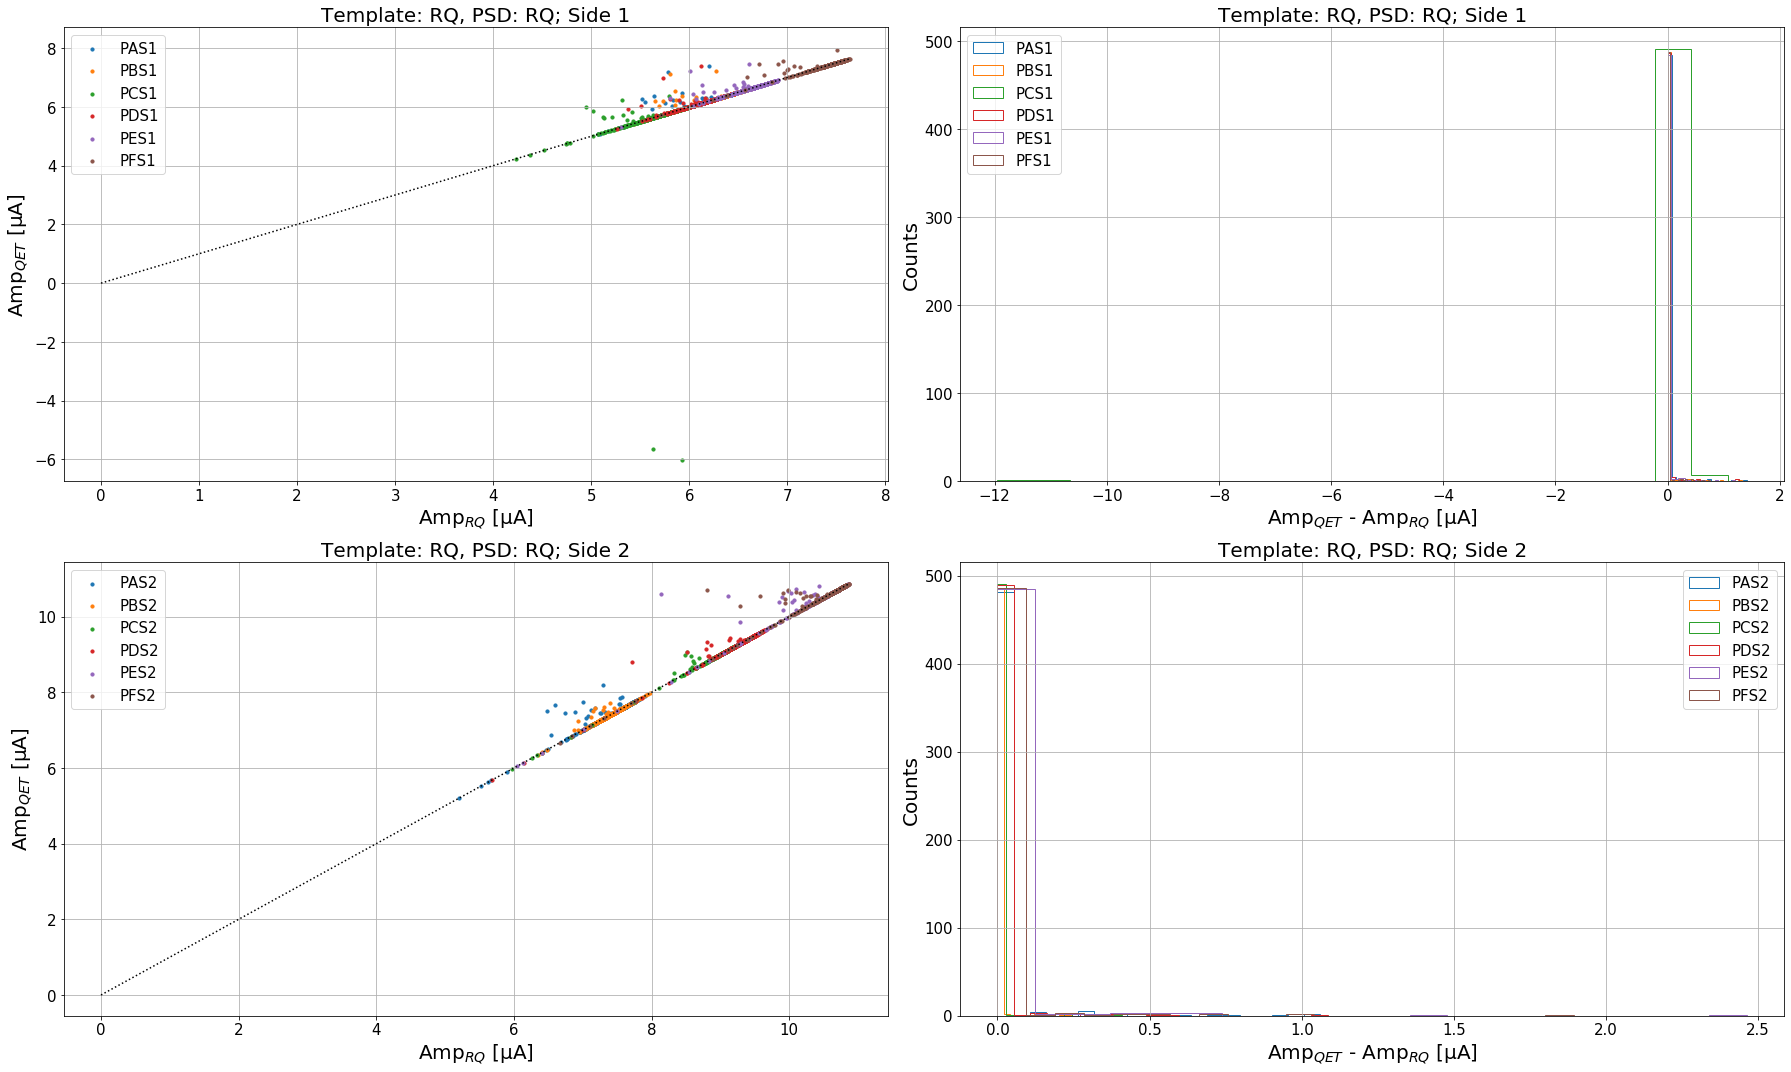

In [25]:
diff1 = plot_comparison(OFqet1, OFrq, 'RQ', 'RQ')

In [26]:
diff1['PCS1'][37]

-1.1949406442838197e-05

In [27]:
outliers = (np.abs(diff1['PCS1']*1e15) > 1) # filter out orders of magnitude above 1e-15

In [28]:
diff1['PCS1'][outliers]

array([ 8.46335228e-07, -1.19494064e-05,  1.06871960e-06,  8.60517405e-08,
        9.02193080e-07,  9.85038461e-08,  5.35629769e-07, -1.12605855e-05,
        1.22652725e-07,  3.93203226e-07,  1.50824225e-07,  9.28783153e-08,
        3.80891753e-07,  5.76979882e-07,  4.34491839e-07,  5.00663996e-07,
        2.08805247e-07])

In [29]:
OFqet1['PCS1'][outliers]

array([[ 5.86317861e-06, -9.24640000e-03,  1.55412096e+06],
       [-6.02382180e-06, -2.60080000e-02,  3.47912703e+06],
       [ 6.01126783e-06, -2.41792000e-02,  1.03319183e+06],
       [ 5.51506172e-06,  2.30560000e-03,  8.61719184e+05],
       [ 6.21859798e-06,  2.61504000e-02,  3.46785471e+06],
       [ 5.72413920e-06,  2.26304000e-02,  1.39646840e+06],
       [ 5.65430093e-06, -1.43856000e-02,  8.35963980e+05],
       [-5.63400368e-06, -2.60080000e-02,  2.60436529e+06],
       [ 5.62620869e-06, -2.13968000e-02,  1.13364219e+06],
       [ 5.81100022e-06,  1.12256000e-02,  8.47861775e+05],
       [ 5.66602221e-06,  1.86336000e-02,  9.09802608e+05],
       [ 5.67585179e-06,  1.14848000e-02,  9.77955426e+05],
       [ 5.70967220e-06,  8.77440000e-03,  8.66256680e+05],
       [ 6.37434274e-06,  2.59808000e-02,  2.86574724e+06],
       [ 5.64660988e-06, -1.76912000e-02,  7.09012673e+05],
       [ 5.62807414e-06, -2.16848000e-02,  7.64839452e+05],
       [ 5.56852285e-06, -2.54304000e-02

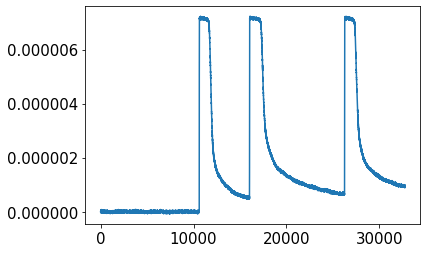

In [30]:
plt.plot(traces_cut_channelwise['PBS2'][outliers][0])

In [31]:
outliers_indices = np.argwhere(outliers)
outliers_indices

array([[ 32],
       [ 37],
       [ 49],
       [ 57],
       [119],
       [130],
       [163],
       [177],
       [213],
       [219],
       [220],
       [245],
       [299],
       [464],
       [472],
       [473],
       [489]])

## Look at traces of negative OFamps

In [32]:
negative_amps = (OFqet1['PCS1'][:,0]<0)

In [33]:
OFqet1['PCS1'][negative_amps]

array([[-6.02382180e-06, -2.60080000e-02,  3.47912703e+06],
       [-5.63400368e-06, -2.60080000e-02,  2.60436529e+06]])

<>:11: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<ipython-input-34-eaca65009f2b>:11: DeprecationWarning: invalid escape sequence \c
  plt.plot(amplitude1*templates['PCS1']*1e6, label=f'Fit $\chi^2 = {chi21:.0f}$')
<ipython-input-34-eaca65009f2b>:19: DeprecationWarning: invalid escape sequence \c
  plt.plot(amplitude2*templates['PCS1']*1e6, label=f'Fit $\chi^2 = {chi22:.0f}$')


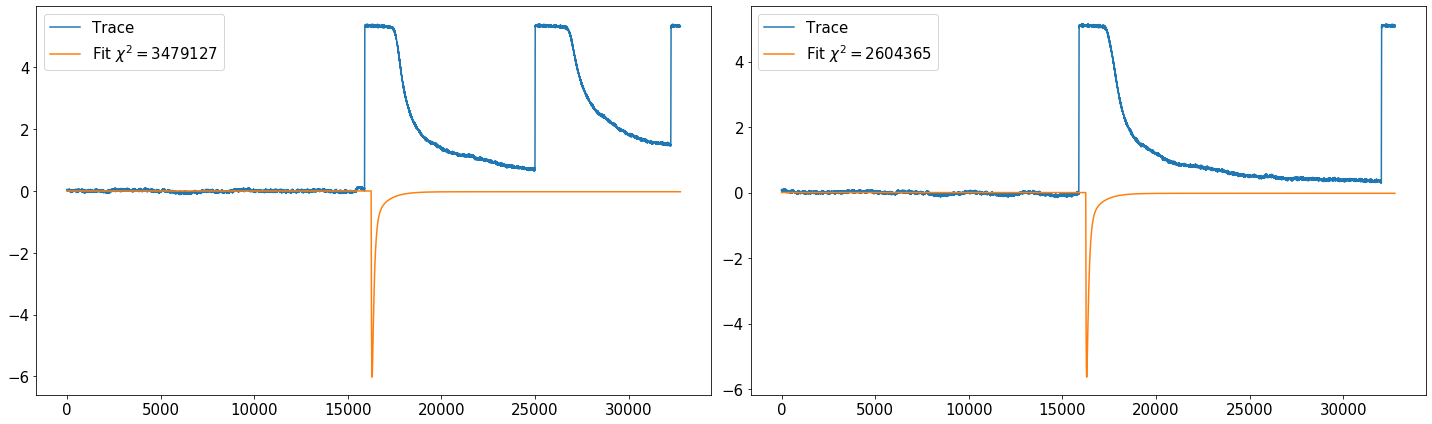

In [34]:
amplitude1, delay1, chi21 = OFqet1['PCS1'][negative_amps][0]
amplitude2, delay2, chi22 = OFqet1['PCS1'][negative_amps][1]



plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(traces_cut_channelwise['PCS1'][negative_amps][0]*1e6, label='Trace')
#plt.plot(amplitude1*np.roll(templates['PCS1'], int(delay1*fs))*1e6, label=f'Fit $\chi^2 = {chi21:.0f}$')
plt.plot(amplitude1*templates['PCS1']*1e6, label=f'Fit $\chi^2 = {chi21:.0f}$')

plt.legend()


plt.subplot(1,2,2)
plt.plot(traces_cut_channelwise['PCS1'][negative_amps][1]*1e6, label='Trace')
#plt.plot(amplitude2*np.roll(templates['PCS1'], int(delay2*fs))*1e6, label=f'Fit $\chi^2 = {chi22:.0f}$')
plt.plot(amplitude2*templates['PCS1']*1e6, label=f'Fit $\chi^2 = {chi22:.0f}$')

plt.legend()


plt.tight_layout()

<>:13: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:13: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:13: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<ipython-input-35-025a38ce0499>:13: DeprecationWarning: invalid escape sequence \c
  plt.plot(amplitude1*np.roll(templates['PCS1'], int(delay1*fs))*1e6, label=f'Fit $\chi^2 = {chi21:.0f}$')
<ipython-input-35-025a38ce0499>:21: DeprecationWarning: invalid escape sequence \c
  plt.plot(amplitude2*np.roll(templates['PCS1'], int(delay2*fs))*1e6, label=f'Fit $\chi^2 = {chi22:.0f}$')


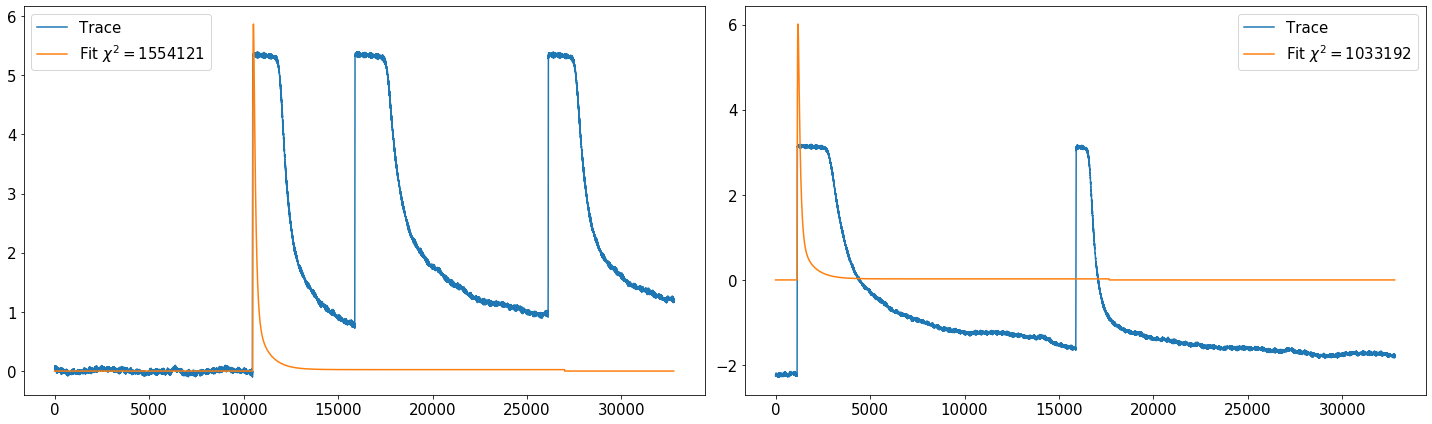

In [35]:
sample_outlier1 = 0
sample_outlier2 = 2

amplitude1, delay1, chi21 = OFqet1['PCS1'][outliers][sample_outlier1]
amplitude2, delay2, chi22 = OFqet1['PCS1'][outliers][sample_outlier2]



plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(traces_cut_channelwise['PCS1'][outliers][sample_outlier1]*1e6, label='Trace')
plt.plot(amplitude1*np.roll(templates['PCS1'], int(delay1*fs))*1e6, label=f'Fit $\chi^2 = {chi21:.0f}$')
#plt.plot(amplitude1*templates['PCS1']*1e6, label=f'Fit $\chi^2 = {chi21:.0f}$')

plt.legend()


plt.subplot(1,2,2)
plt.plot(traces_cut_channelwise['PCS1'][outliers][sample_outlier2]*1e6, label='Trace')
plt.plot(amplitude2*np.roll(templates['PCS1'], int(delay2*fs))*1e6, label=f'Fit $\chi^2 = {chi22:.0f}$')
#plt.plot(amplitude2*templates['PCS1']*1e6, label=f'Fit $\chi^2 = {chi22:.0f}$')

plt.legend()


plt.tight_layout()

Why do some bad pile up traces lead to negative OFamps and some don't?! Also, for negative amps template isn't shifted correctly by delay, for positive amps it is -> Negative amps also lead to wrong delays.

## Need to cut out bad traces like this (e.g. pile-ups)!

In [36]:
outliers_channels_combined = np.zeros(samplesize)
for chan in channames: # check where bad traces are for every channel
    outlier_channel = (np.abs(diff1[chan]*1e15) > 1) # filter out orders of magnitude above 1e-15
    outliers_channels_combined += outlier_channel # combine all channels for simplicity
np.argwhere(outliers_channels_combined)

array([[ 12],
       [ 32],
       [ 37],
       [ 38],
       [ 43],
       [ 49],
       [ 51],
       [ 57],
       [ 82],
       [119],
       [121],
       [130],
       [163],
       [176],
       [177],
       [213],
       [219],
       [220],
       [245],
       [282],
       [283],
       [293],
       [299],
       [316],
       [323],
       [339],
       [341],
       [343],
       [406],
       [454],
       [464],
       [469],
       [472],
       [473],
       [489]])

In [37]:
OFqet1_cut_outliers = {}
OFrq_cut_outliers = {}
for chan in channames:
    OFqet1_cut_outliers[chan] = OFqet1[chan][outliers_channels_combined==False]
    OFrq_cut_outliers[chan] = OFrq[chan][outliers_channels_combined==False]


In [38]:
OFqet1_cut_outliers['PAS1'].shape

(465, 3)

In [39]:
traces_cut_channelwise['PAS1'][outliers==False].shape

(483, 32768)

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

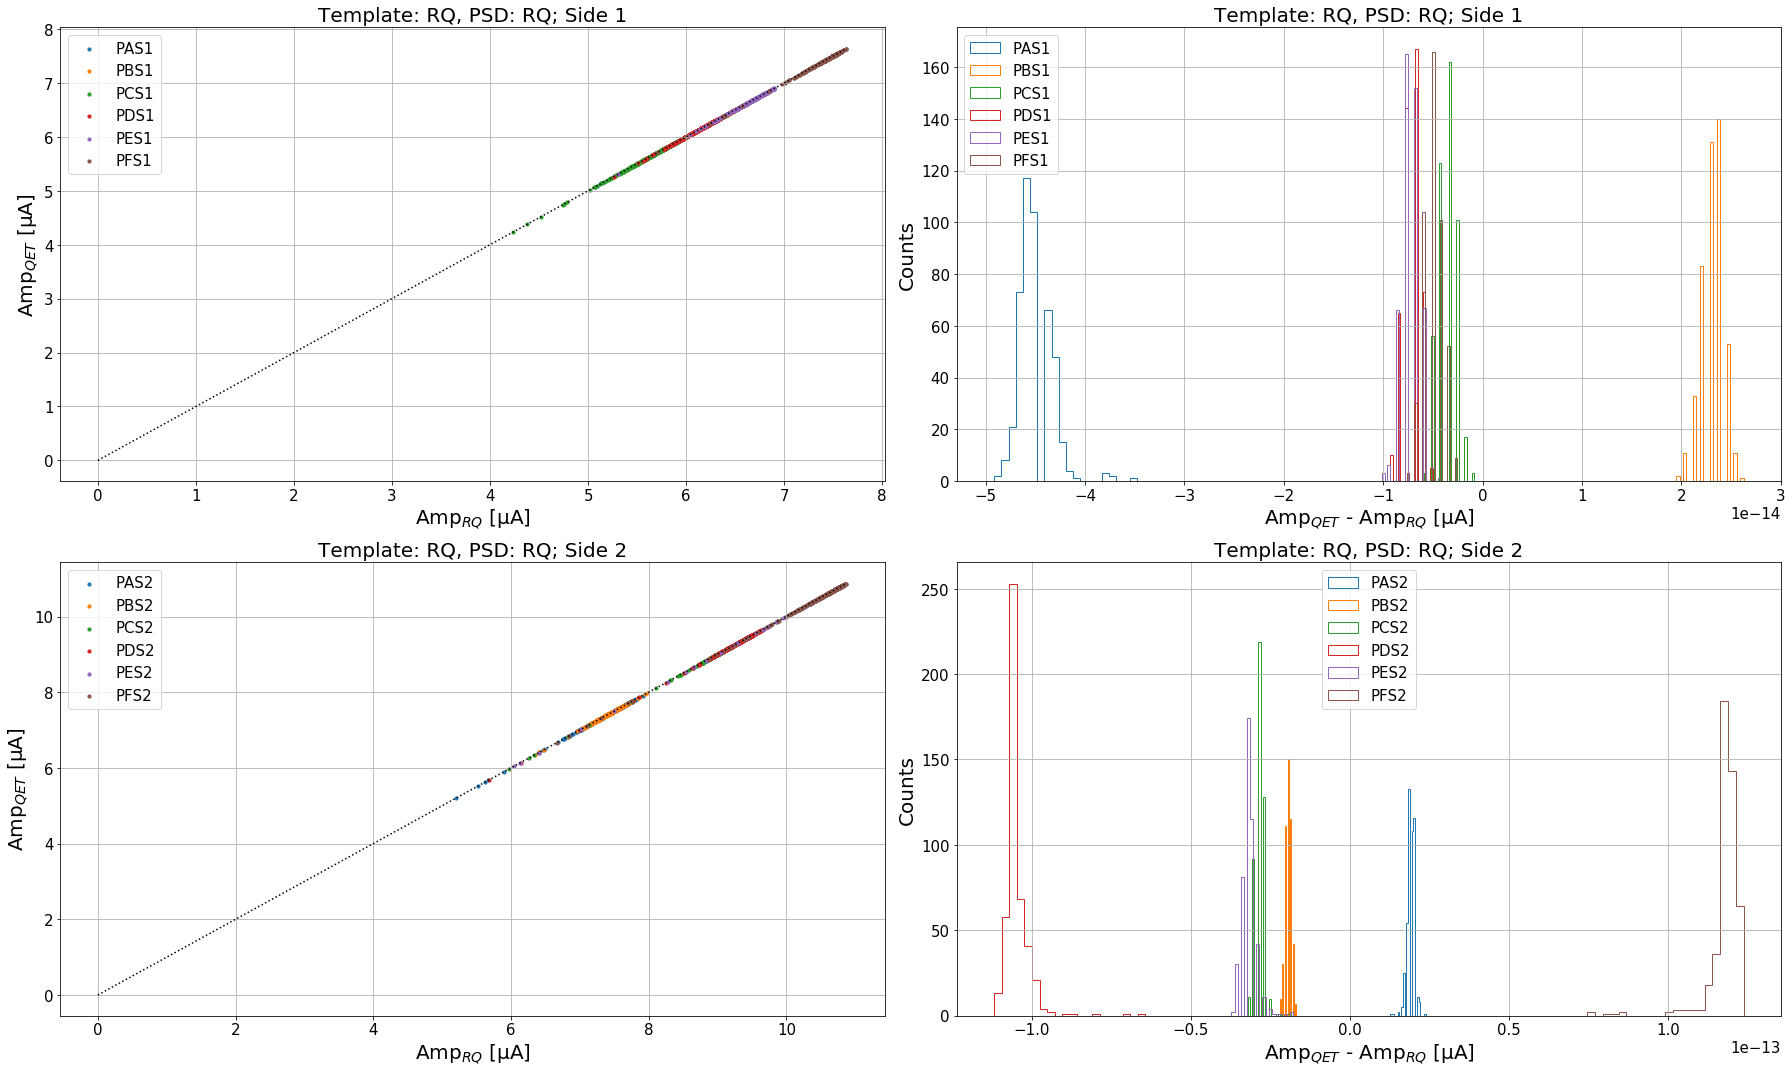

In [40]:
diff1_cut_outliers = plot_comparison(OFqet1_cut_outliers, OFrq_cut_outliers, 'RQ', 'RQ')

In [41]:
traces_cut_channelwise_cut_outliers = {}
for chan in channames:
    traces_cut_channelwise_cut_outliers[chan] = traces_cut_channelwise[chan][outliers_channels_combined==False]

In [42]:
#OFqet1_cut_outliers['PAS1'] == compare_QETpy_RQs(templates, psd, traces_cut_channelwise_cut_outliers)[0]['PAS1']

## Fitcheck

<>:14: DeprecationWarning: invalid escape sequence \c
<>:14: DeprecationWarning: invalid escape sequence \c
<>:14: DeprecationWarning: invalid escape sequence \c
<ipython-input-43-5d195a369ab7>:14: DeprecationWarning: invalid escape sequence \c
  plt.title(f'$\chi^2 = {chi2:.2f}$')


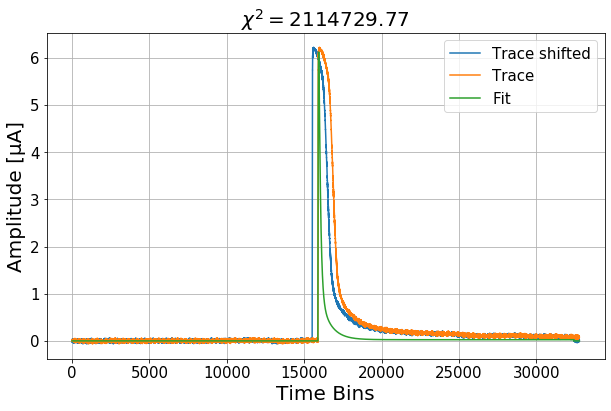

In [43]:
sample = 50
c = 'PAS1'

amplitude = OFqet1[c][sample][0]
delay = OFqet1[c][sample][1]
chi2 = OFqet1[c][sample][2]

plt.figure(figsize=(10,6))
# do both pulses have to be shifted according to their respective delays?
plt.plot(np.roll(traces_cut_channelwise[c][sample], int(OFrq[c][sample][1]*fs))*1e6, label='Trace shifted')
plt.plot(traces_cut_channelwise[c][sample]*1e6, label='Trace')
plt.plot(amplitude*np.roll(templates[c], int(delay*fs))*1e6, label='Fit')
plt.grid()
plt.title(f'$\chi^2 = {chi2:.2f}$')
plt.legend()
plt.xlabel('Time Bins')
plt.ylabel('Amplitude [µA]')
plt.show()

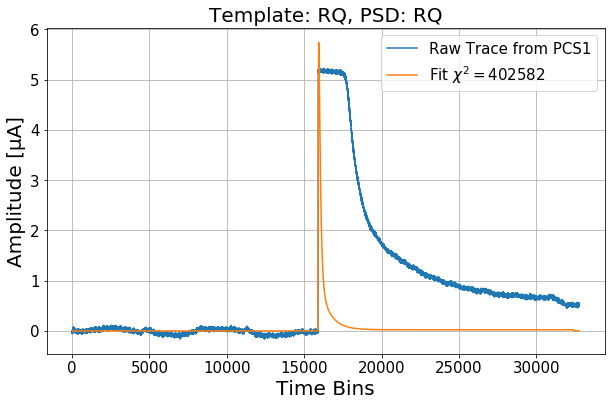

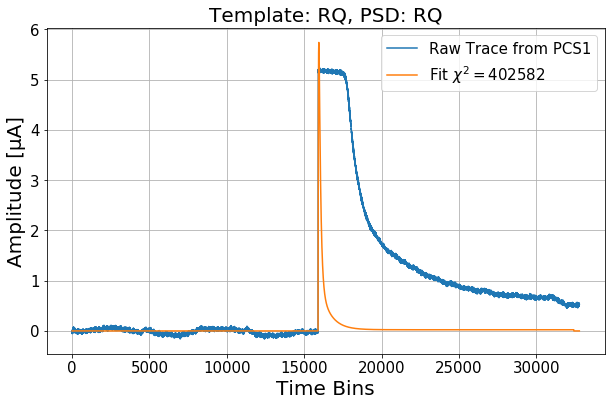

In [44]:
plot_fit(OFqet1_cut_outliers, traces_dict=traces_cut_channelwise_cut_outliers, templates_dict=templates, channel='PCS1', sample=32, method_temp='RQ', method_psd='RQ')
plot_fit(OFrq_cut_outliers, traces_dict=traces_cut_channelwise_cut_outliers, templates_dict=templates, channel='PCS1', sample=32, method_temp='RQ', method_psd='RQ')

Makes no difference whether using the Amplitude, Delay and $\chi^2$ calculated by QETpy with Template and PSD from RQs or directly the values given in the RQs since they barely differ.

## Build own Template

In [45]:
templates_own = {}
for chan in channames:
    
    # traces should already be aligned
    templates_own[chan] = np.mean(traces_cut_channelwise[chan][outliers_channels_combined == 0], axis=0)
    #templates_own[chan] -= np.mean(templates_own[chan][:10000]) # subtract baseline offset
    templates_own[chan] /= np.max(templates_own[chan]) # normalize to 1
    
#plt.plot(templates_own['PCS2'])

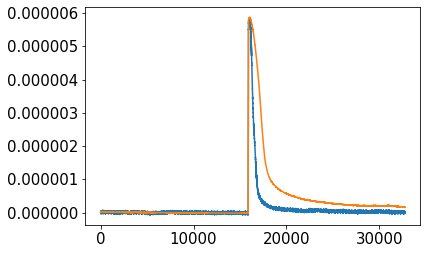

In [46]:
plt.plot(traces_cut_channelwise['PAS1'][outliers_channels_combined == 0][0])
plt.plot(templates_own['PAS1']*OFqet1['PAS1'][0][0])

## Build own PSD

Already saw above that the best way to construct the PSD is to use the uncut traces and apply autocut to them. Now just do that channelwise:

In [47]:
psd_own, psd_own_unfolded = {}, {}
freq_own, freq_own_unfolded = {}, {}
for chan in channames:
    
    autocut = qp.autocuts(traces_channelwise[chan], fs=fs)
    freq_own[chan], psd_own[chan] = qp.calc_psd(traces_channelwise[chan][autocut], fs=fs)  # pass traces in A, returns in A^2/Hz
    freq_own_unfolded[chan], psd_own_unfolded[chan] = qp.calc_psd(traces_channelwise[chan][autocut], fs=fs, folded_over=False)
    # take sqrt because function compare_QETpy_RQs squares psd
    psd_own_unfolded[chan] = np.sqrt(psd_own_unfolded[chan]) 

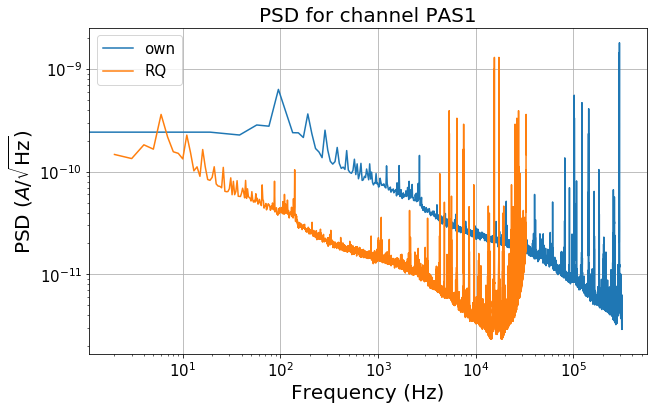

In [48]:
plt.figure(figsize=(10,6))
plt.loglog(freq_own['PAS1'],np.sqrt(psd_own['PAS1']), label='own')
plt.loglog(freq['PAS1'][2:],psd['PAS1'][1:], label='RQ')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD $(A/\sqrt{\mathrm{Hz}})$')
plt.title('PSD for channel PAS1')
plt.show()

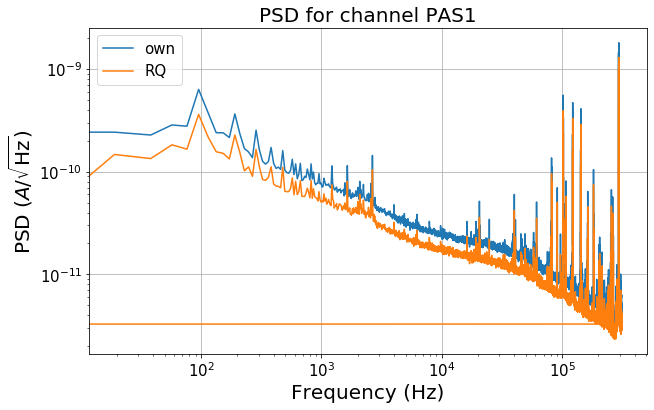

In [49]:
plt.figure(figsize=(10,6))
plt.loglog(freq_own['PAS1'],np.sqrt(psd_own['PAS1']), label='own')
plt.loglog(freq_own_unfolded['PAS1'],psd['PAS1'], label='RQ')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD $(A/\sqrt{\mathrm{Hz}})$')
plt.title('PSD for channel PAS1')
plt.show()

-> RQs or calc_psd give wrong/shifted frequency axis!

## Try out different combinations

In [50]:
# create OFs with all possible combinations of template/psd own/RQ
# OFrq remains the same throughout, bit annoyoing, should change code accordingly... ¯\_(ツ)_/¯
OFqet2 = compare_QETpy_RQs(templates_own, psd, traces_cut_channelwise_cut_outliers)[0]
OFqet3 = compare_QETpy_RQs(templates, psd_own_unfolded, traces_cut_channelwise_cut_outliers)[0]
OFqet4 = compare_QETpy_RQs(templates_own, psd_own_unfolded, traces_cut_channelwise_cut_outliers)[0]

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

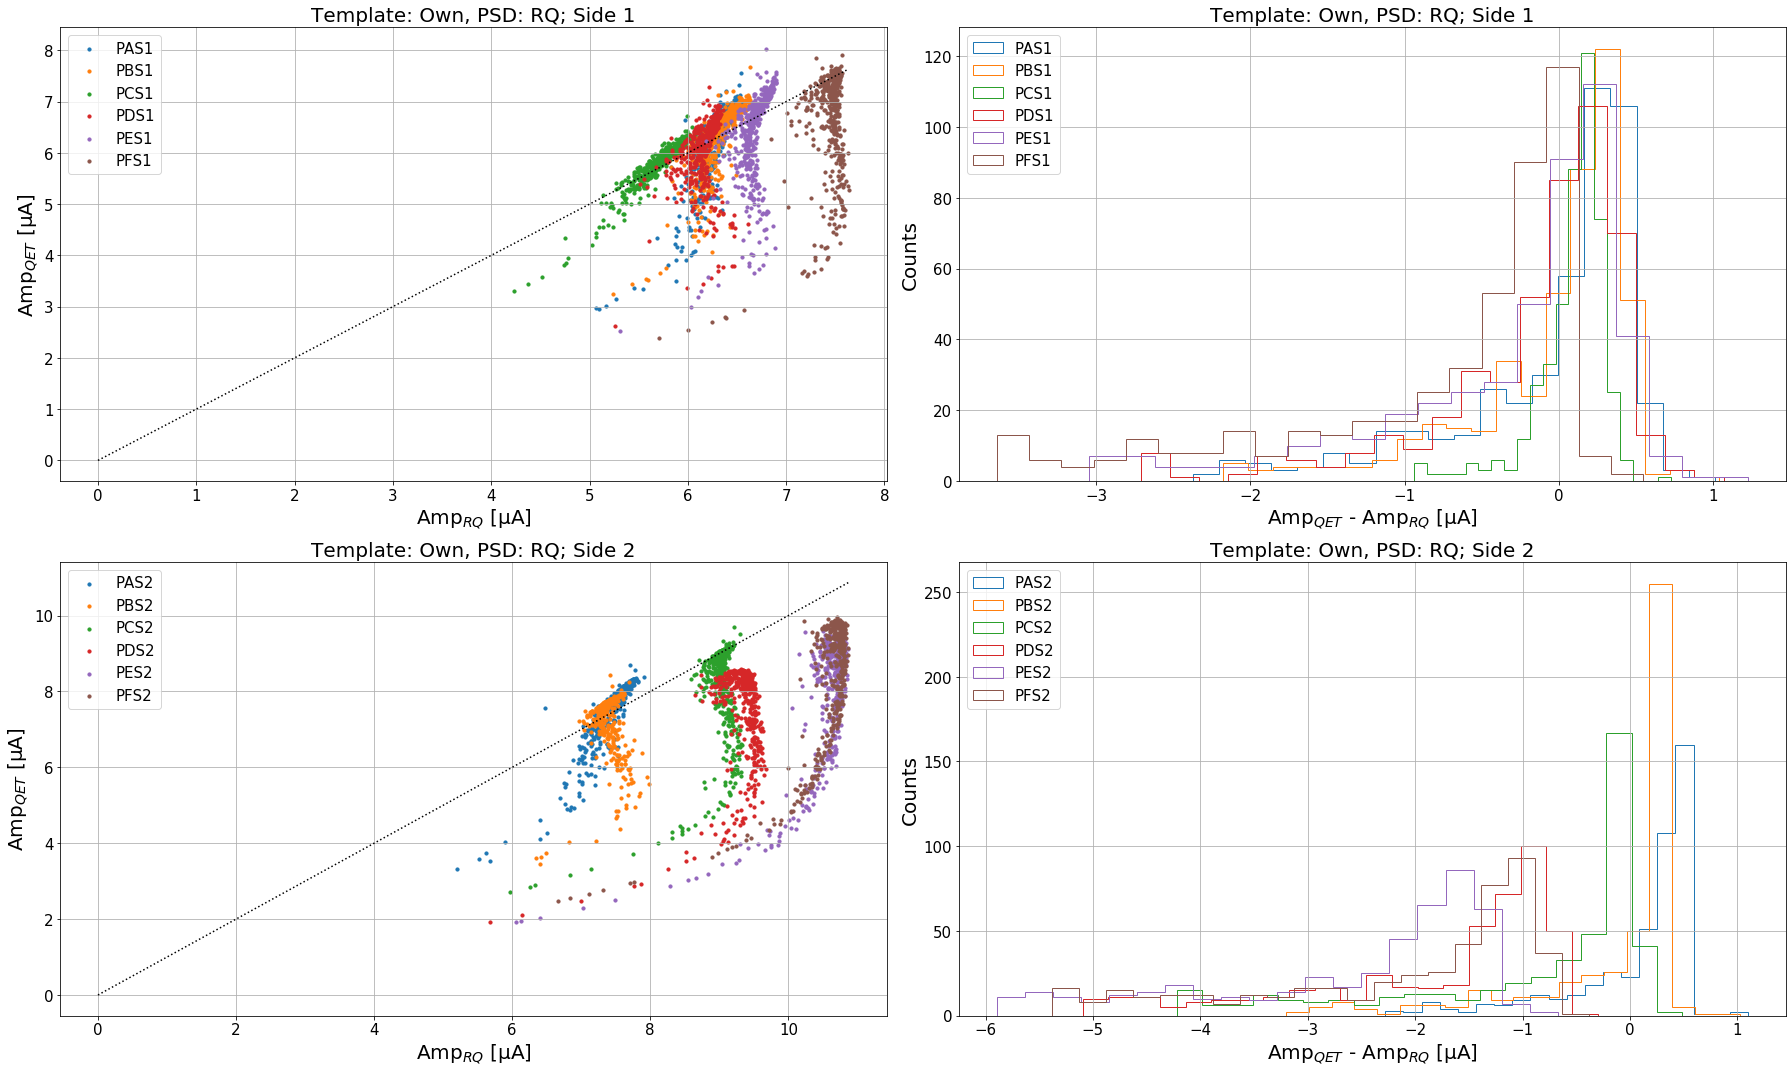

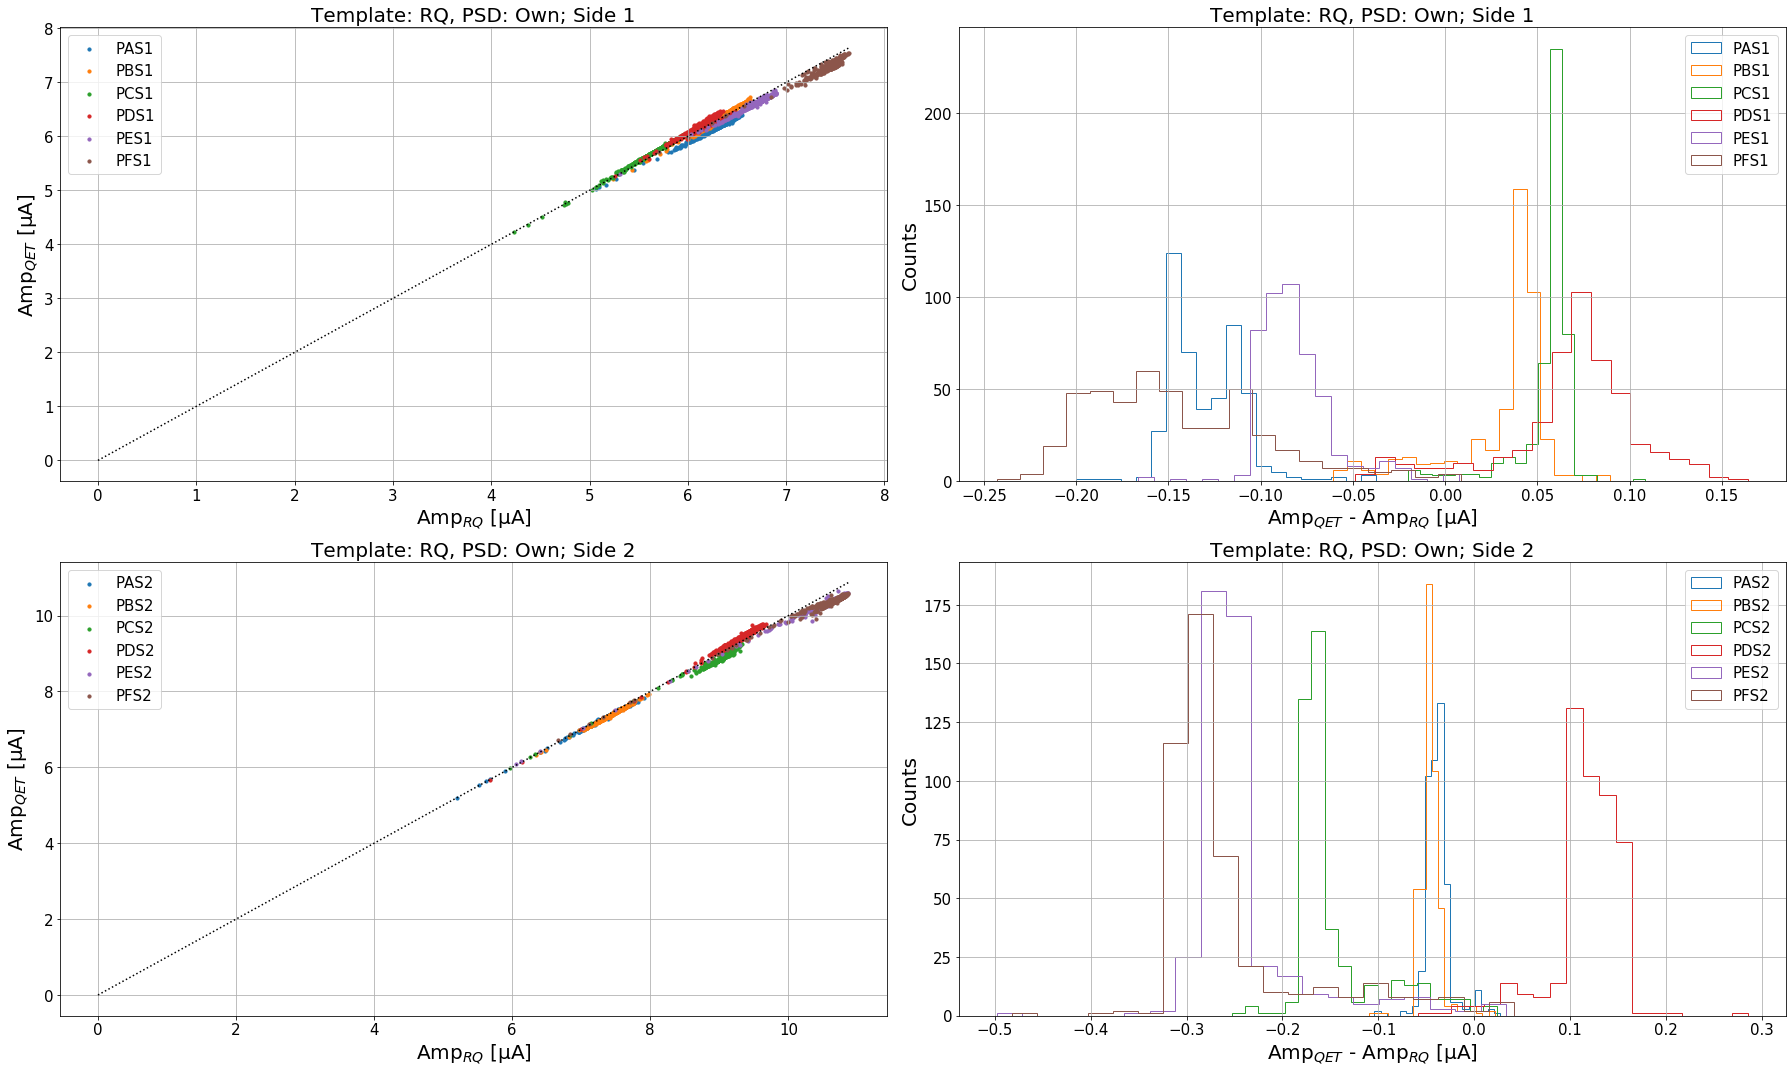

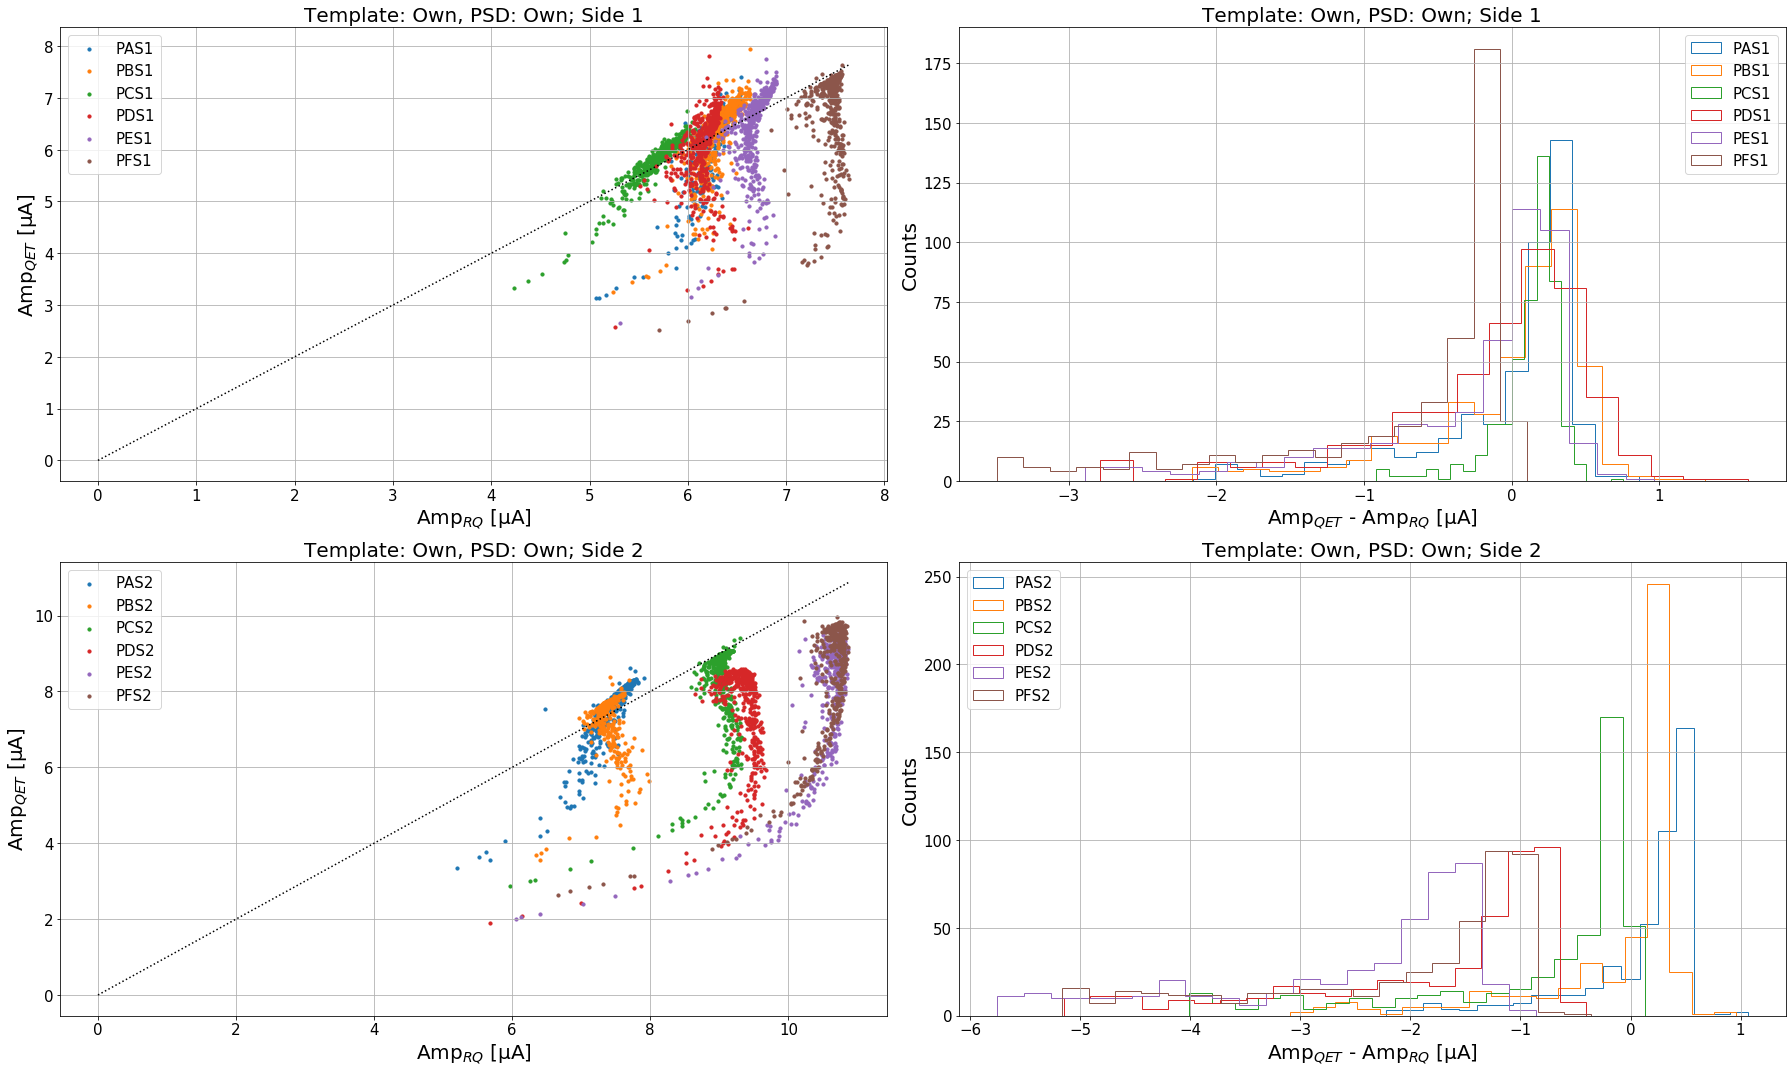

In [51]:
diff2 = plot_comparison(OFqet2, OFrq_cut_outliers, 'Own', 'RQ')
diff3 = plot_comparison(OFqet3, OFrq_cut_outliers, 'RQ', 'Own')
diff4 = plot_comparison(OFqet4, OFrq_cut_outliers, 'Own', 'Own')

--> Own Template seems to suck :( 
    Or: The RQ Amplitude is much higher than the one calculated via QETpy. Maybe because the RQ template is the one that         sucks after all and not mine (╯°□°）╯︵ ┻━┻
    The RQ Template looks like an analytic double exponential function with the parameters for the fall/rise time and amplitude given by the RQs... Whereas mine is generated by averaging over the very traces (even only over the good traces) it is being fit to, so naturally that performs well.

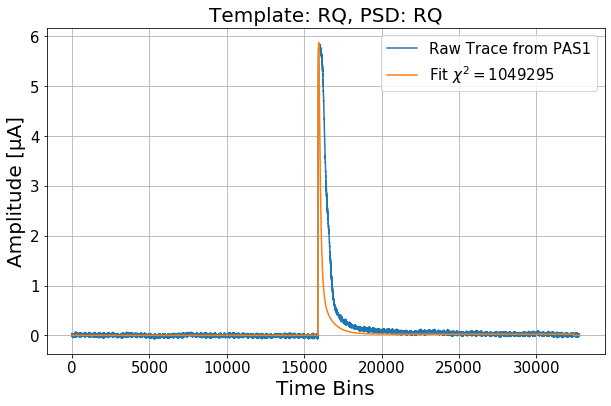

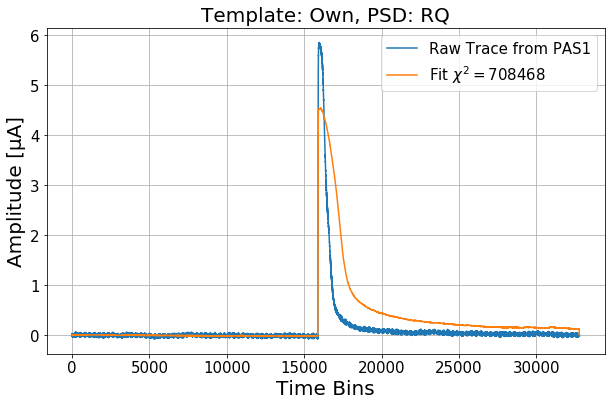

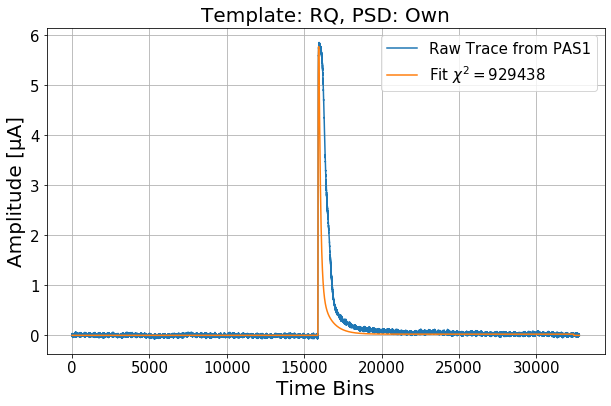

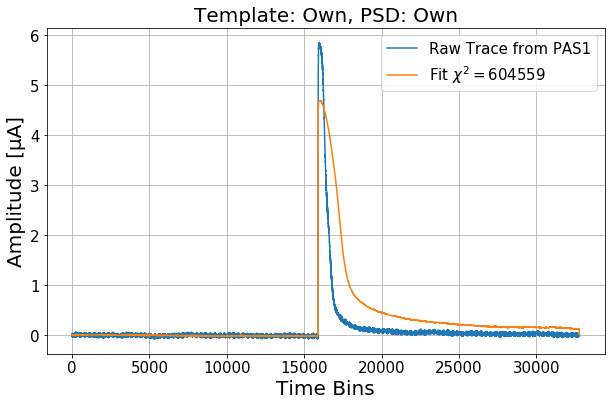

In [52]:
sample = 0
channel = 'PAS1'

plot_fit(OFqet1_cut_outliers, traces_dict=traces_cut_channelwise_cut_outliers, templates_dict=templates, 
         channel=channel, sample=sample, method_temp='RQ', method_psd='RQ')
plot_fit(OFqet2, traces_dict=traces_cut_channelwise_cut_outliers, templates_dict=templates_own, 
         channel=channel, sample=sample, method_temp='Own', method_psd='RQ')
plot_fit(OFqet3, traces_dict=traces_cut_channelwise_cut_outliers, templates_dict=templates, 
         channel=channel, sample=sample, method_temp='RQ', method_psd='Own')
plot_fit(OFqet4, traces_dict=traces_cut_channelwise_cut_outliers, templates_dict=templates_own, 
         channel=channel, sample=sample, method_temp='Own', method_psd='Own')

Own Template does however have a way better $\chi^2$ (one order of magnitude). PSD from RQs or own does't make that much of a difference like the different templates do.

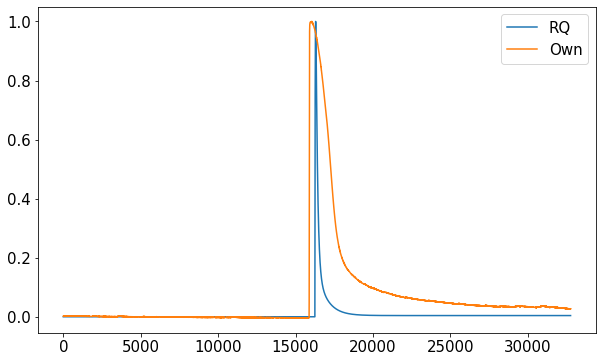

In [53]:
plt.figure(figsize=(10,6))
plt.plot(templates['PAS1'], label='RQ')
plt.plot(templates_own['PAS1'],label='Own')

plt.legend()

## Also look at comparing plots of $\chi^2$

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

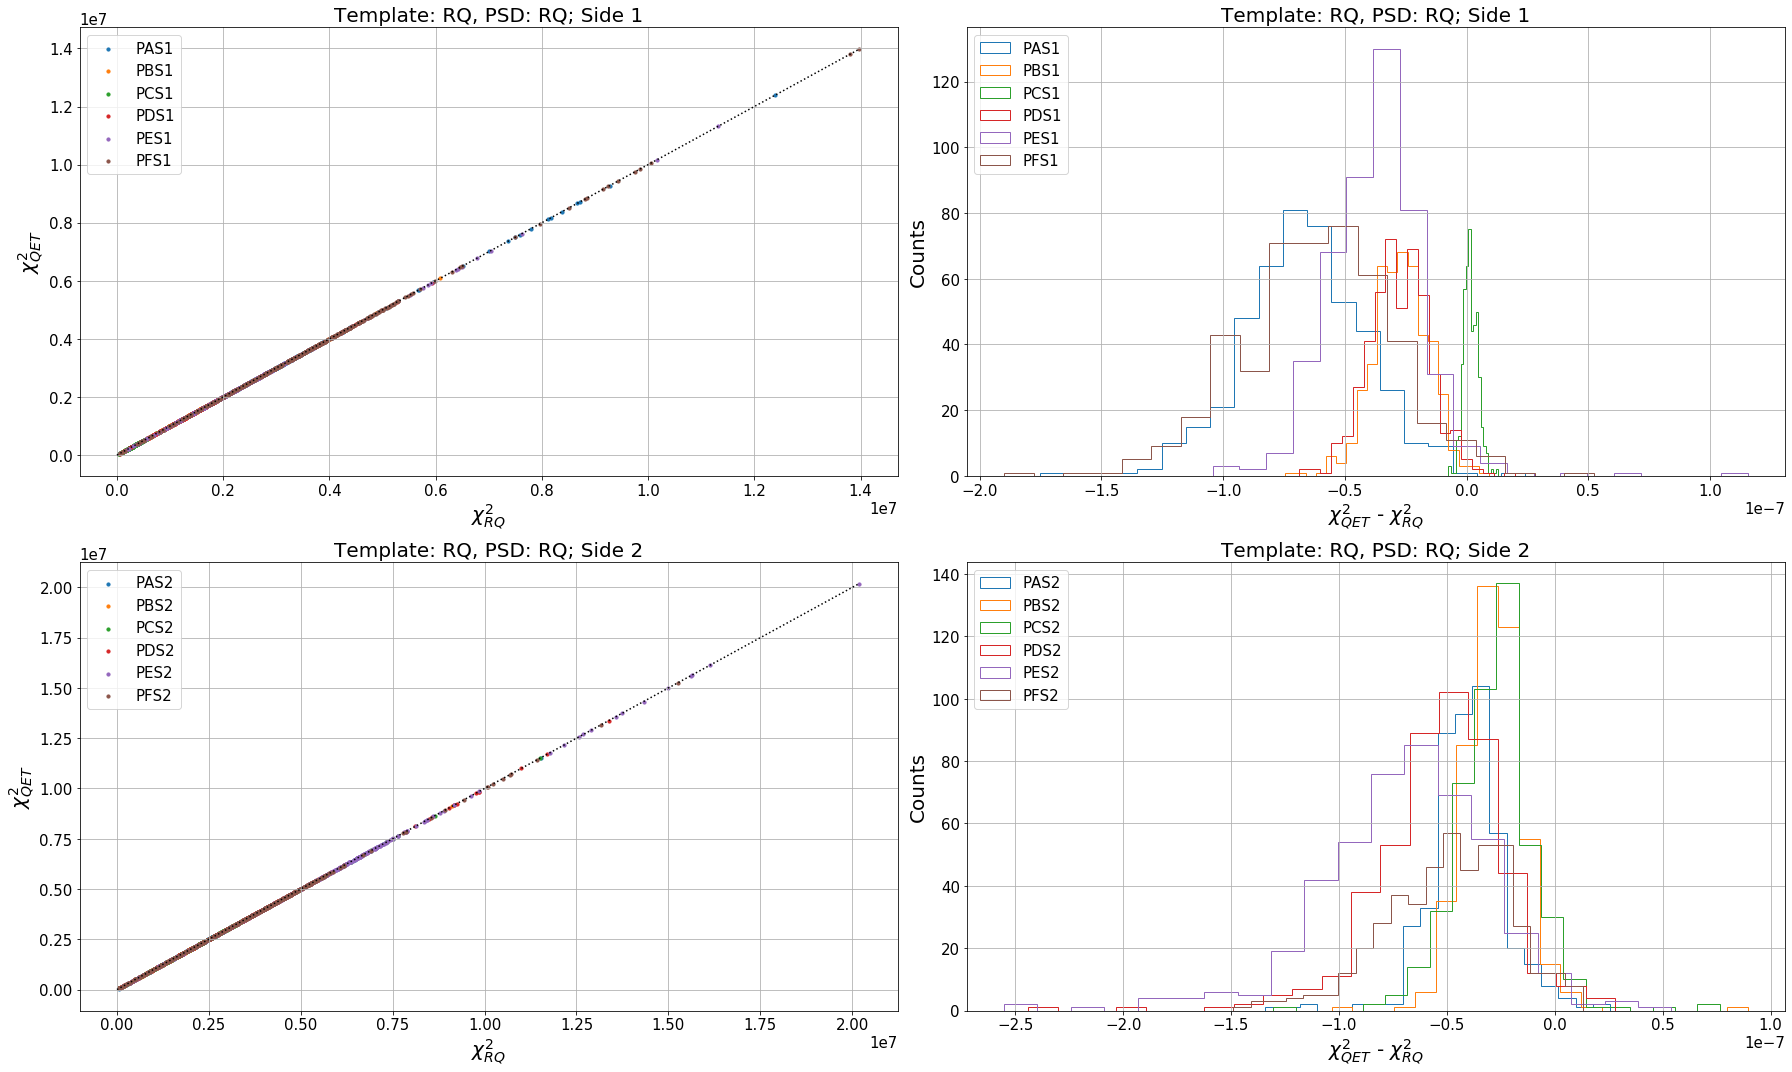

In [54]:
diff1_chi2 = plot_comparison(OFqet1_cut_outliers, OFrq_cut_outliers, 'RQ', 'RQ', 'chi2')

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

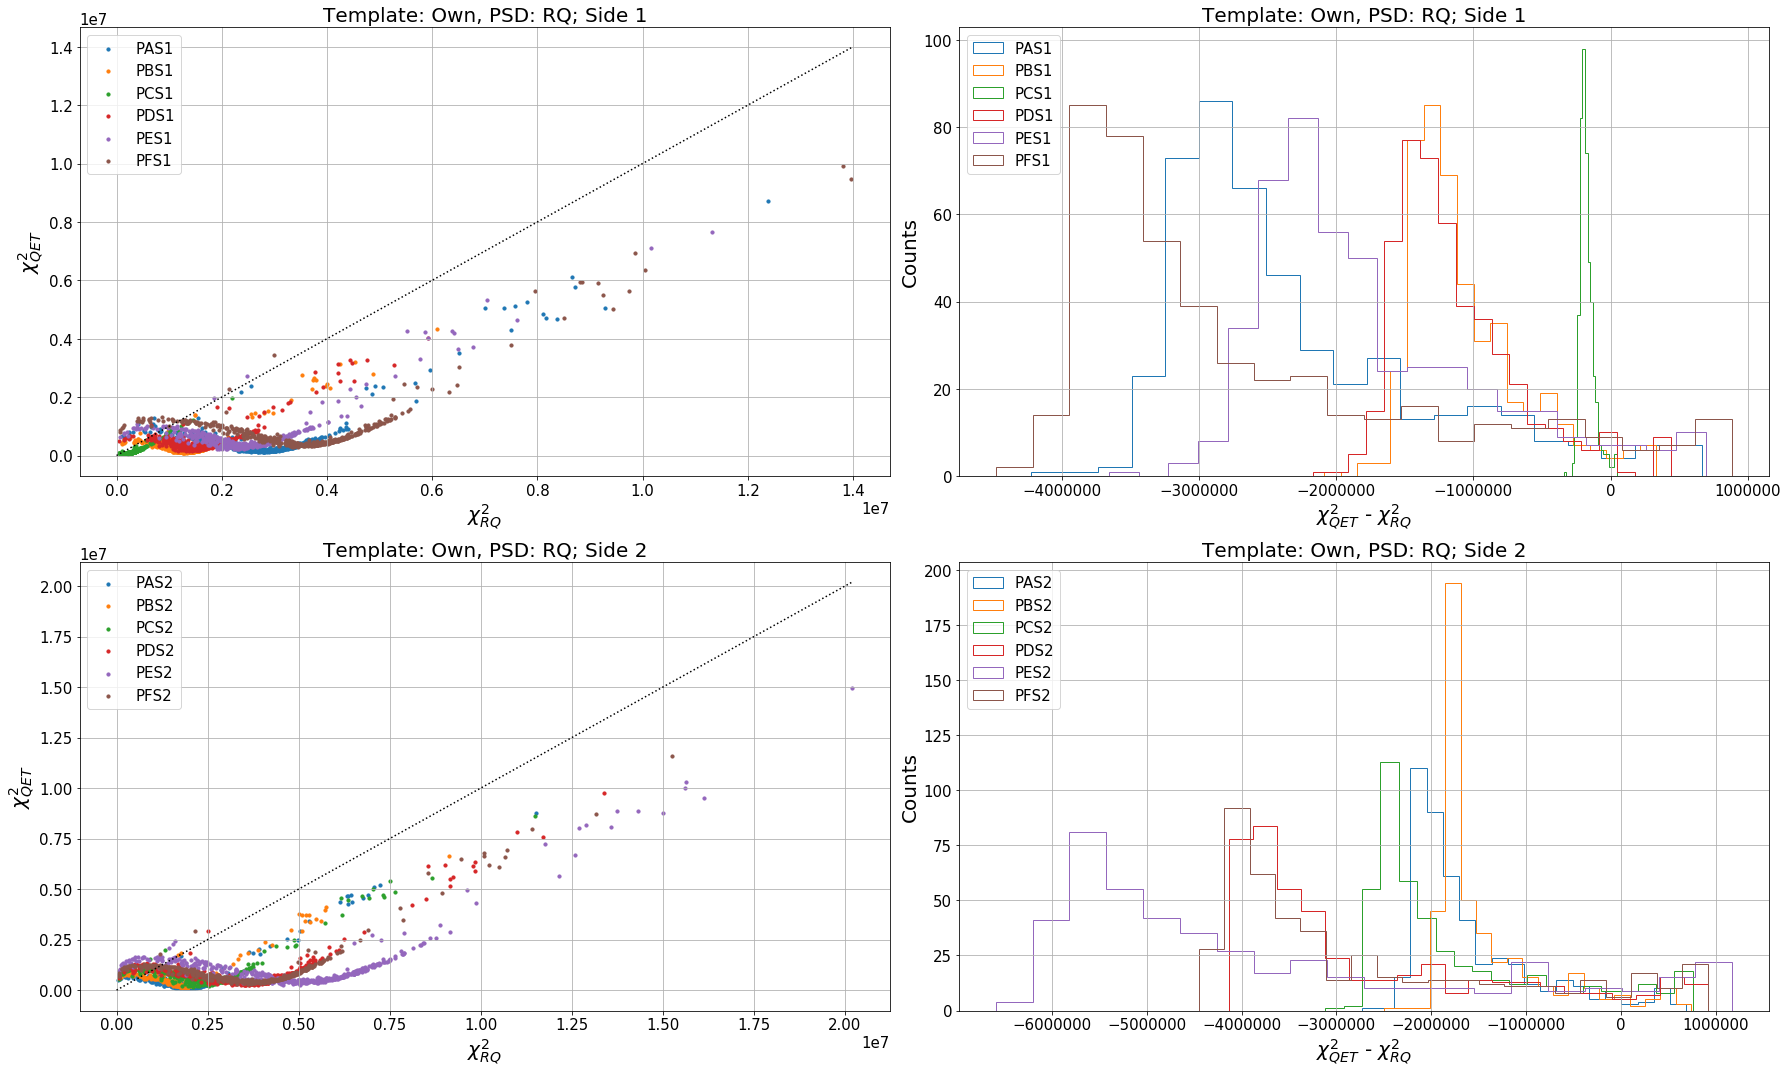

In [55]:
diff2_chi2 = plot_comparison(OFqet2, OFrq_cut_outliers, 'Own', 'RQ', 'chi2')

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

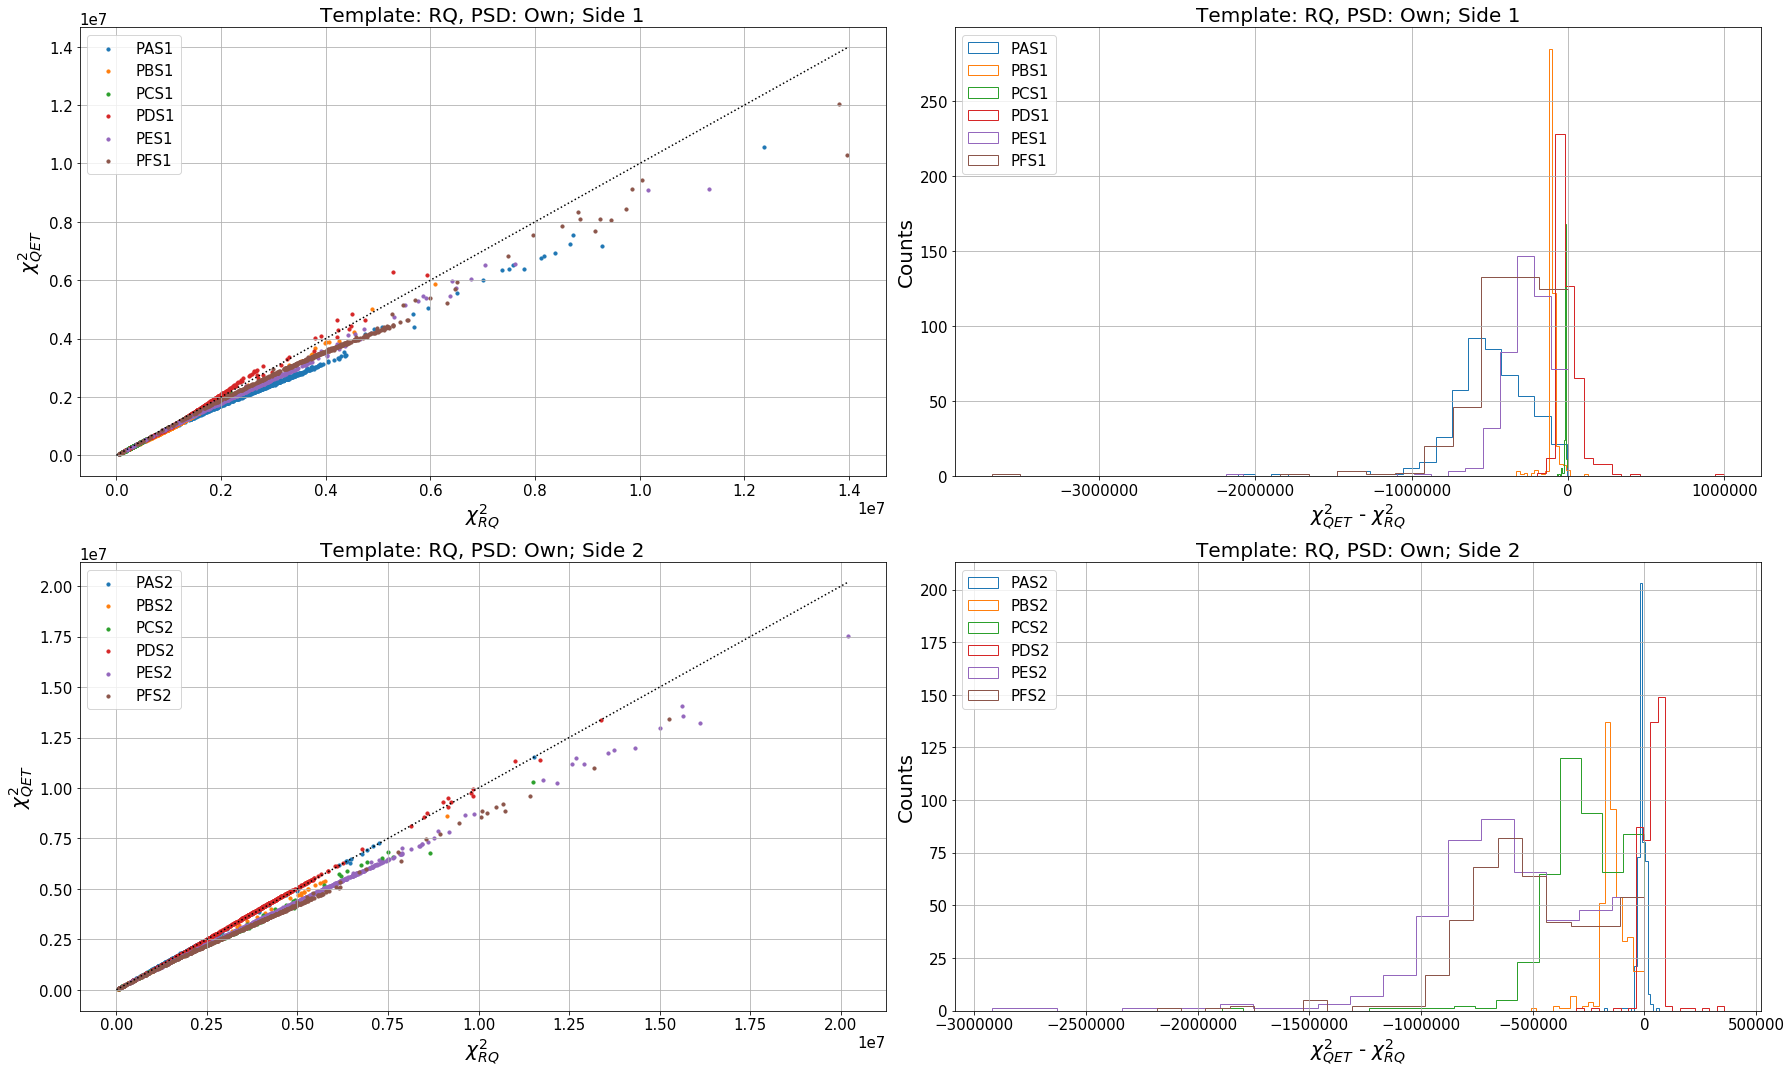

In [56]:
diff3_chi2 = plot_comparison(OFqet3, OFrq_cut_outliers, 'RQ', 'Own', 'chi2')

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykern

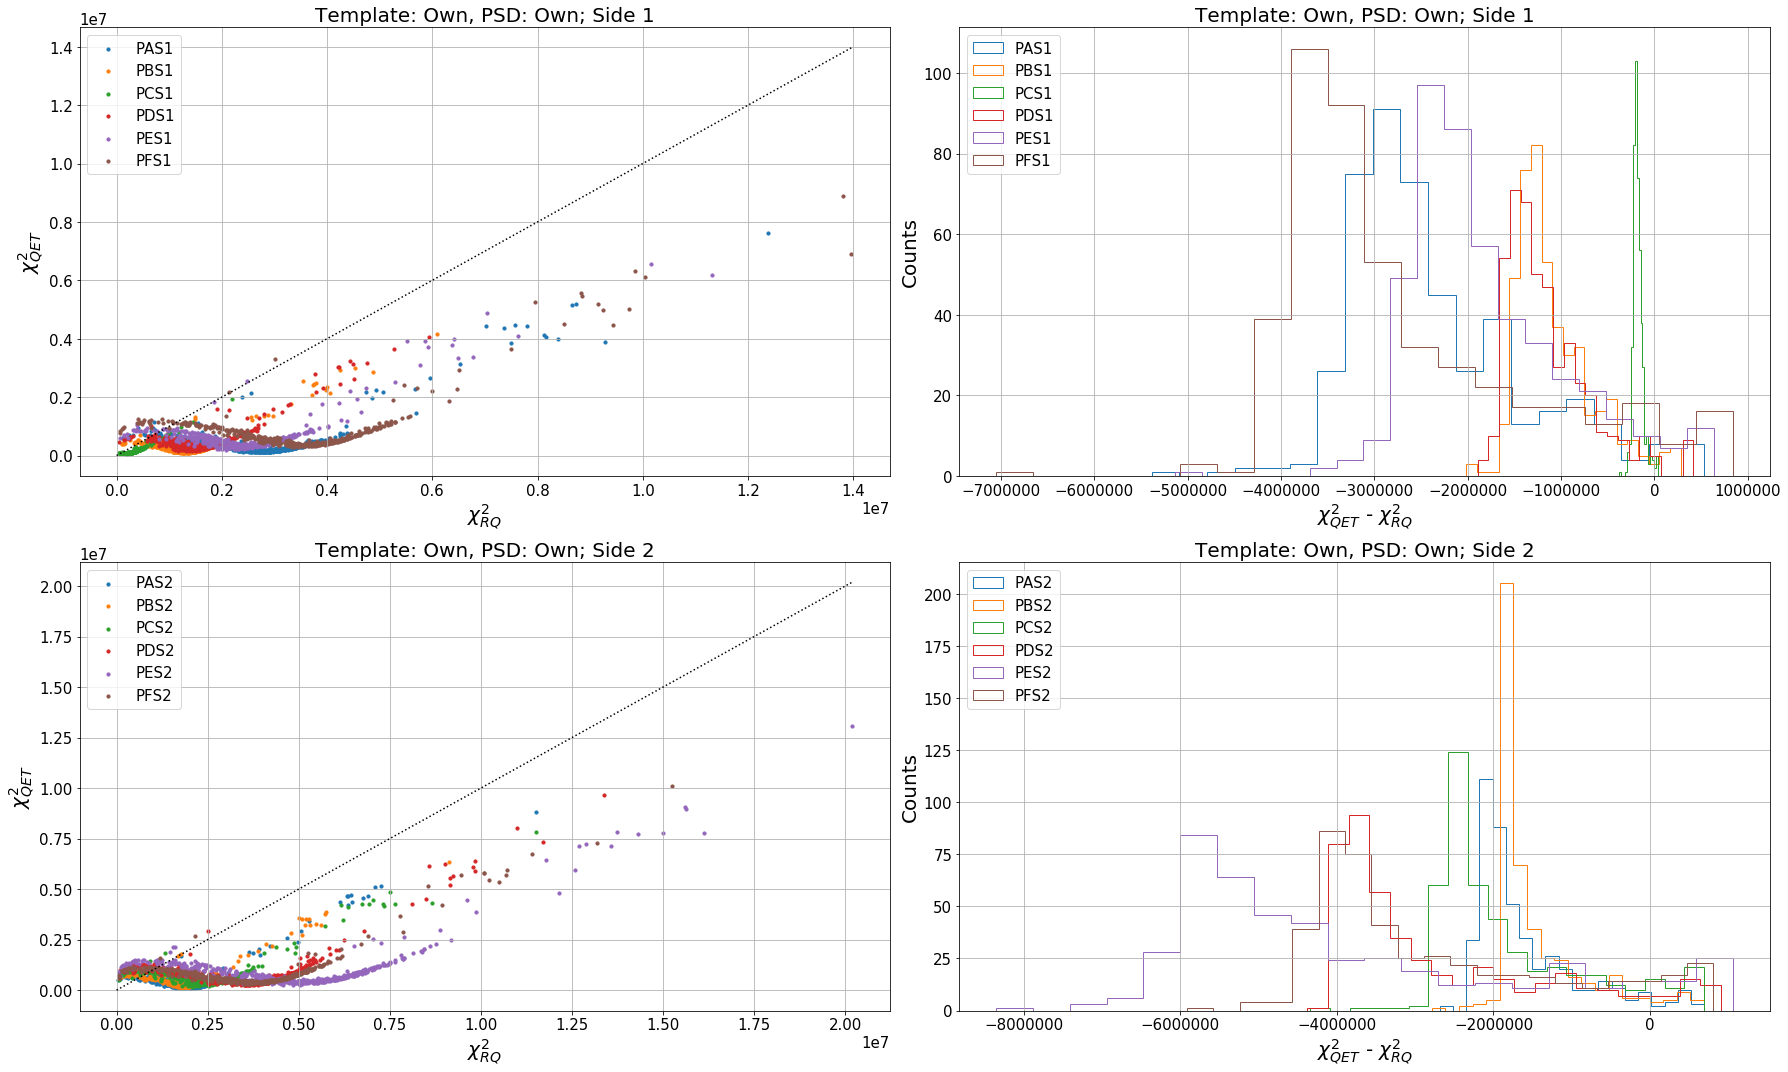

In [57]:
diff4_chi2 = plot_comparison(OFqet4, OFrq_cut_outliers, 'Own', 'Own', 'chi2')

## Look at $\chi^2$ as a function of the Trace's Amplitude

<>:12: DeprecationWarning: invalid escape sequence \c
<>:24: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \c
<>:24: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \c
<>:24: DeprecationWarning: invalid escape sequence \c
<ipython-input-168-eb538e1352fe>:12: DeprecationWarning: invalid escape sequence \c
  plt.ylabel('OF $\chi^2$ RQ')
<ipython-input-168-eb538e1352fe>:24: DeprecationWarning: invalid escape sequence \c
  plt.ylabel('OF $\chi^2$ RQ')


Text(0.5, 1.0, 'Side 2')

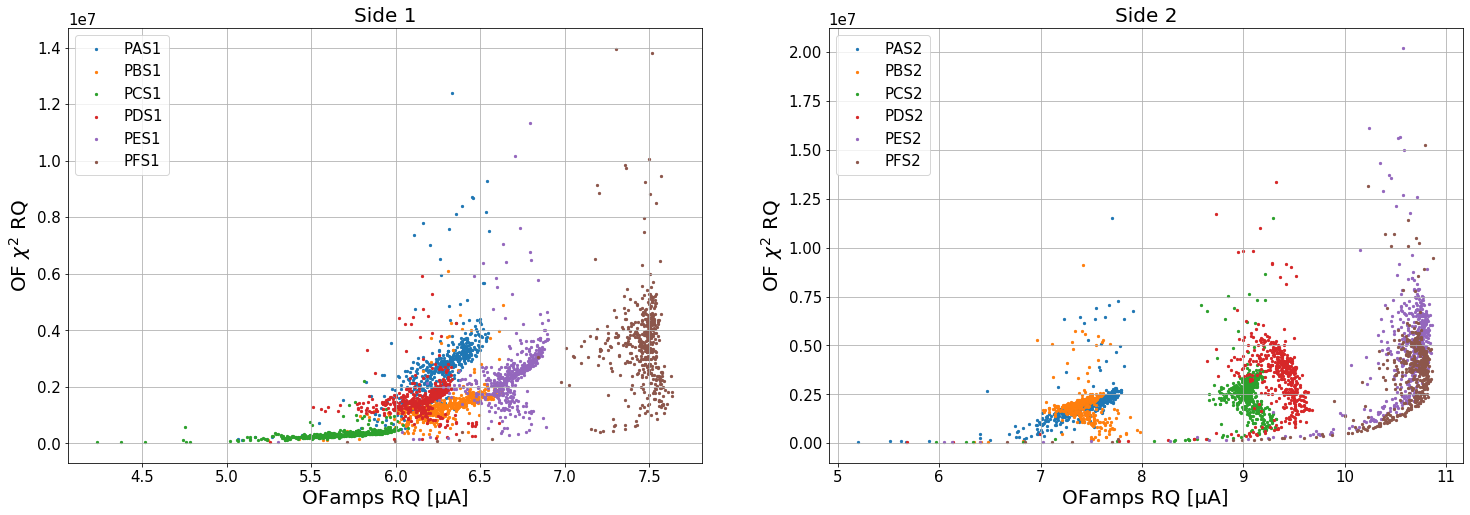

In [168]:
plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
for chan in channames[:6]:
    amps = OFrq_cut_outliers[chan][:,0]*1e6
    chis = OFrq_cut_outliers[chan][:,2]
    plt.scatter(amps,chis, s=5, label=chan)
    
plt.legend()
plt.grid()
plt.xlabel('OFamps RQ [µA]')
plt.ylabel('OF $\chi^2$ RQ')
plt.title('Side 1')
    
plt.subplot(1,2,2)
for chan in channames[6:]:
    amps = OFrq_cut_outliers[chan][:,0]*1e6
    chis = OFrq_cut_outliers[chan][:,2]
    plt.scatter(amps,chis, s=5, label=chan)
    
plt.legend()
plt.grid()
plt.xlabel('OFamps RQ [µA]')
plt.ylabel('OF $\chi^2$ RQ')
plt.title('Side 2')

<>:12: DeprecationWarning: invalid escape sequence \c
<>:24: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \c
<>:24: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \c
<>:24: DeprecationWarning: invalid escape sequence \c
<ipython-input-133-fd9b541ce307>:12: DeprecationWarning: invalid escape sequence \c
  plt.ylabel('OF $\chi^2$ QET')
<ipython-input-133-fd9b541ce307>:24: DeprecationWarning: invalid escape sequence \c
  plt.ylabel('OF $\chi^2$ QET')


Text(0.5, 1.0, 'Template: Own, PSD: Own; Side 2')

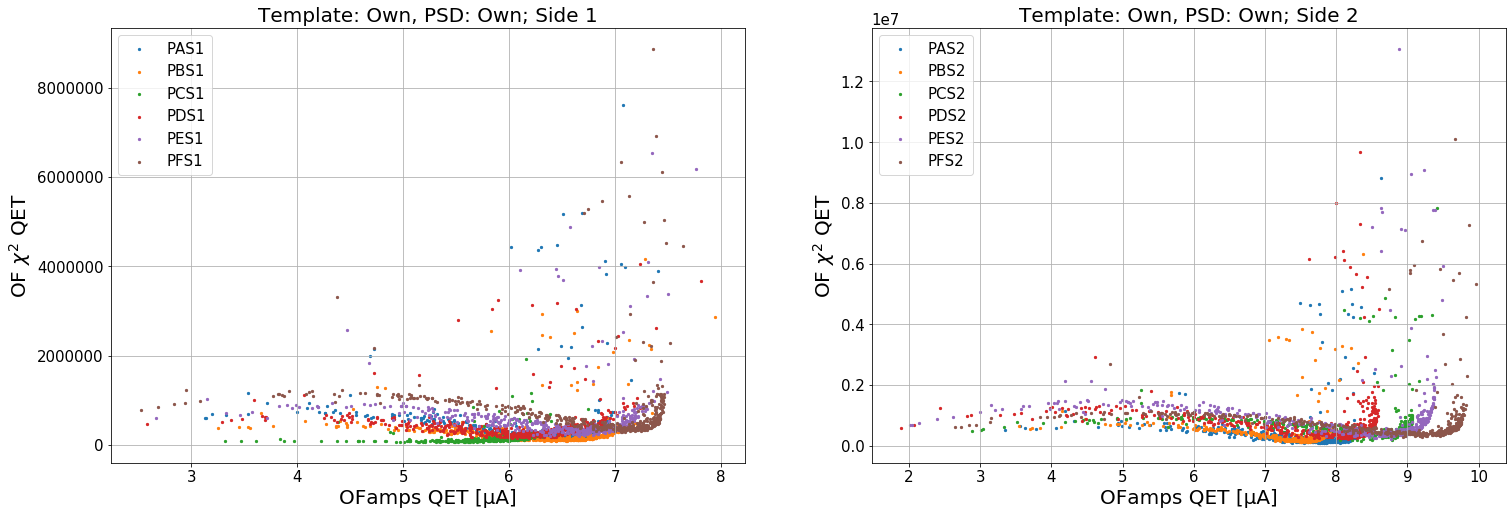

In [133]:
plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
for chan in channames[:6]:
    amps = OFqet4[chan][:,0]*1e6
    chis = OFqet4[chan][:,2]
    plt.scatter(amps,chis, s=5, label=chan)
    
plt.legend()
plt.grid()
plt.xlabel('OFamps QET [µA]')
plt.ylabel('OF $\chi^2$ QET')
plt.title('Template: Own, PSD: Own; Side 1')
    
plt.subplot(1,2,2)
for chan in channames[6:]:
    amps = OFqet4[chan][:,0]*1e6
    chis = OFqet4[chan][:,2]
    plt.scatter(amps,chis, s=5, label=chan)
    
plt.legend()
plt.grid()
plt.xlabel('OFamps QET [µA]')
plt.ylabel('OF $\chi^2$ QET')
plt.title('Template: Own, PSD: Own; Side 2')

For my own Template and PSD the $\chi^2$ are generally a bit lower and thers is a much smaller tendency for $\chi^2$ to increase with the amplitude than for the RQ's template and PSD. This is a hint that the RQ's template works better for lower amplitudes, i.e. we might need different templates for different energy regions.

## Look at Traces of different regions/energies in scatterplot

### Determine Distribution of RQ $\chi^2$

<>:11: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<ipython-input-134-fe8d60b3c651>:11: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('OF $\chi^2$ RQ')
<ipython-input-134-fe8d60b3c651>:21: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('OF $\chi^2$ RQ')
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance

Text(0, 0.5, 'Counts')

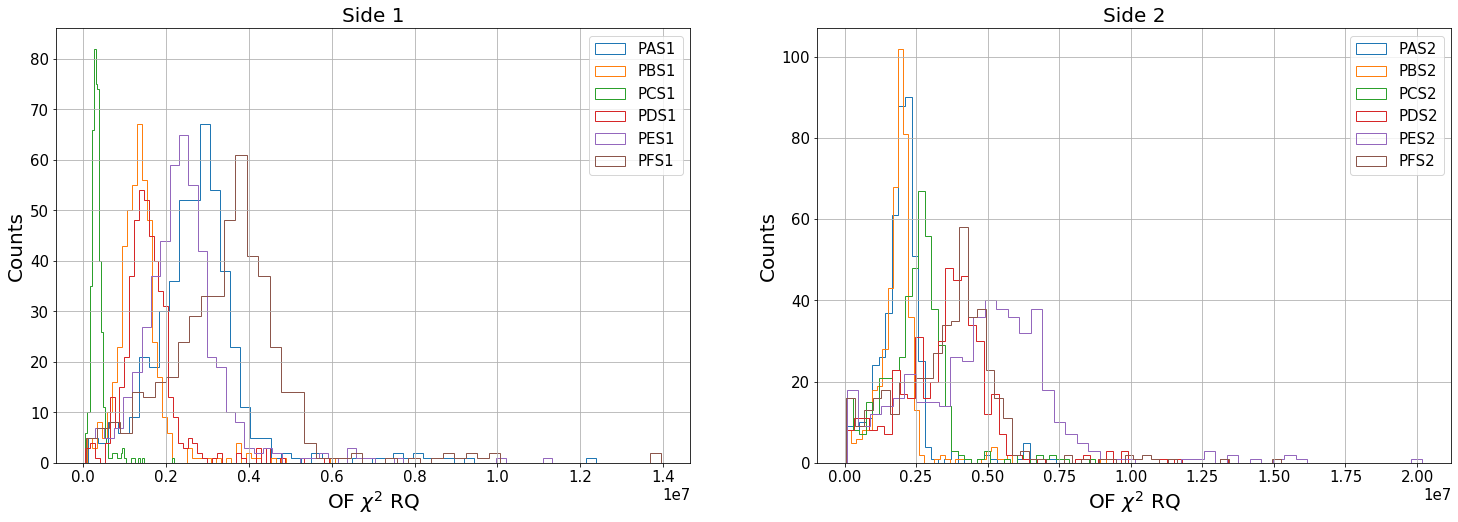

In [134]:
plt.figure(figsize=(25,8))
counts, bins, patches = {},{},{}
for chan in channames[:6]:
    plt.subplot(1,2,1)
    counts[chan], bins[chan], patches[chan] = plt.hist(OFrq_cut_outliers[chan][:,2], bins=50, histtype='step', label=chan)
    #bins[chan] = plt.hist(OFrq_cut_outliers[chan][:,0]*1e6, bins=50, histtype='step', label=chan)[1]

plt.legend()
plt.grid()
plt.title('Side 1')
plt.xlabel('OF $\chi^2$ RQ')
plt.ylabel('Counts')
for chan in channames[6:]:
    plt.subplot(1,2,2)
    counts[chan], bins[chan], patches[chan] = plt.hist(OFrq_cut_outliers[chan][:,2], bins=50, histtype='step', label=chan)
    #bins[chan] = plt.hist(OFrq_cut_outliers[chan][:,0]*1e6, bins=50, histtype='step', label=chan)[1]

plt.legend()
plt.grid()
plt.title('Side 2')
plt.xlabel('OF $\chi^2$ RQ')
plt.ylabel('Counts')
#%matplotlib inline

<>:11: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<ipython-input-216-c9c380131d00>:11: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('OF $\chi^2$ RQ')
<ipython-input-216-c9c380131d00>:21: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('OF $\chi^2$ RQ')
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance

Text(0, 0.5, 'Counts')

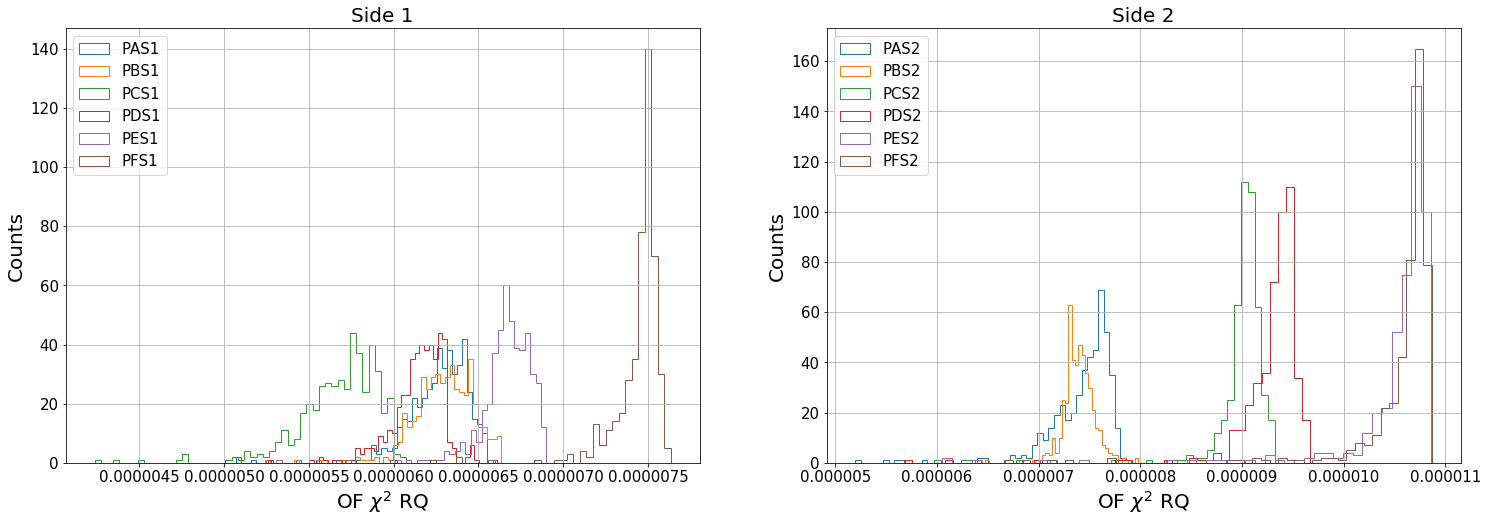

In [216]:
plt.figure(figsize=(25,8))
counts, bins, patches = {},{},{}
for chan in channames[:6]:
    plt.subplot(1,2,1)
    counts[chan], bins[chan], patches[chan] = plt.hist(OFrq_cut_outliers[chan][:,0], bins=50, histtype='step', label=chan)
    #bins[chan] = plt.hist(OFrq_cut_outliers[chan][:,0]*1e6, bins=50, histtype='step', label=chan)[1]

plt.legend()
plt.grid()
plt.title('Side 1')
plt.xlabel('OF $\chi^2$ RQ')
plt.ylabel('Counts')
for chan in channames[6:]:
    plt.subplot(1,2,2)
    counts[chan], bins[chan], patches[chan] = plt.hist(OFrq_cut_outliers[chan][:,0], bins=50, histtype='step', label=chan)
    #bins[chan] = plt.hist(OFrq_cut_outliers[chan][:,0]*1e6, bins=50, histtype='step', label=chan)[1]

plt.legend()
plt.grid()
plt.title('Side 2')
plt.xlabel('OF $\chi^2$ RQ')
plt.ylabel('Counts')
#%matplotlib inline

All channels have similar distributions in their amplitudes: a maximum with a sharp flank right of that maximum and a longer tail left of it at smaller amplitudes.

All channels have similar distributions in their $\chi^2$: a maximum and a longer tail right of it at higher $\chi^2$.

In [212]:
chi_regions = {}
for chan in channames:
    chi_regions[chan] = np.zeros((3, OFrq_cut_outliers['PAS1'].shape[0]), dtype='int')
    maxbin = counts[chan].argmax()
    maximum = bins[chan][maxbin]
    #print(maxbin, maximum)
    chi_regions[chan][0] = ( OFrq_cut_outliers[chan][:,2] >= 1.3*maximum )
    chi_regions[chan][1] = ( OFrq_cut_outliers[chan][:,2] < 1.3*maximum ) & ( OFrq_cut_outliers[chan][:,2] >= 0.7*maximum )
    chi_regions[chan][2] = ( OFrq_cut_outliers[chan][:,2] <= 0.7*maximum )
    
    # sanity check that every trace/amplitude only falls into one region
    #print(np.sum(energy_regions[chan], axis=0) == np.ones(OFrq_cut_outliers['PAS1'].shape[0], dtype='int'))
    

In [174]:
OFrq_cut_outliers['PBS1'][chi_regions['PBS1'][2]==True].shape

(64, 3)

<>:19: DeprecationWarning: invalid escape sequence \c
<>:20: DeprecationWarning: invalid escape sequence \c
<>:31: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<>:20: DeprecationWarning: invalid escape sequence \c
<>:31: DeprecationWarning: invalid escape sequence \c
<>:19: DeprecationWarning: invalid escape sequence \c
<>:20: DeprecationWarning: invalid escape sequence \c
<>:31: DeprecationWarning: invalid escape sequence \c
<ipython-input-215-e22dd87e2176>:19: DeprecationWarning: invalid escape sequence \c
  plt.plot(amp*np.roll(templates[c], int(delay*fs)), label=f'Fit RQ $\chi^2={chisq:2.1e}$')
<ipython-input-215-e22dd87e2176>:20: DeprecationWarning: invalid escape sequence \c
  plt.plot(ampqet*np.roll(templates_own[c], int(delayqet*fs)), label=f'Fit QET $\chi^2={chisqqet:2.1e}$')
<ipython-input-215-e22dd87e2176>:31: DeprecationWarning: invalid escape sequence \c
  plt.title(title + f' $\chi^2$, OFamp RQ: {amp:.1f} µA')


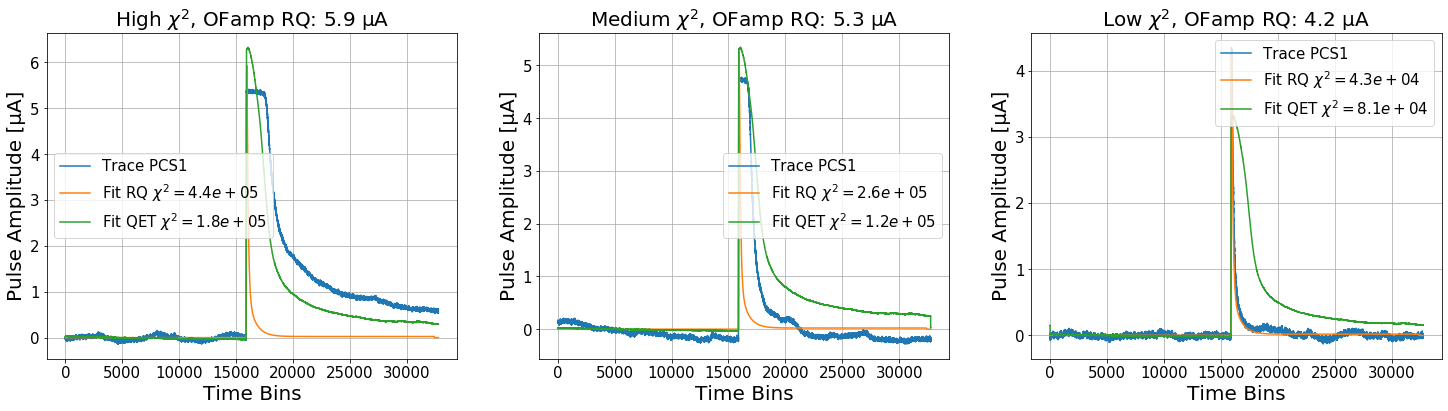

In [215]:
sample = 10
c = 'PCS1'

plt.figure(figsize=(25,6))
for chi in range(3):

    trace = traces_cut_channelwise_cut_outliers[c][chi_regions[c][chi]==True][sample]*1e6
    amp = OFrq_cut_outliers[c][chi_regions[c][chi]==True][sample][0]*1e6
    delay = OFrq_cut_outliers[c][chi_regions[c][chi]==True][sample][1]
    chisq = OFrq_cut_outliers[c][chi_regions[c][chi]==True][sample][2]
    
    ampqet = OFqet4[c][chi_regions[c][chi]==True][sample][0]*1e6
    delayqet = OFqet4[c][chi_regions[c][chi]==True][sample][1]
    chisqqet = OFqet4[c][chi_regions[c][chi]==True][sample][2]

    
    plt.subplot(1,3,chi+1)
    plt.plot(trace, label='Trace ' + c)
    plt.plot(amp*np.roll(templates[c], int(delay*fs)), label=f'Fit RQ $\chi^2={chisq:2.1e}$')
    plt.plot(ampqet*np.roll(templates_own[c], int(delayqet*fs)), label=f'Fit QET $\chi^2={chisqqet:2.1e}$')
    plt.legend()
    plt.grid()
    plt.xlabel('Time Bins')
    plt.ylabel('Pulse Amplitude [µA]')
    if chi == 0:
        title = 'High'
    elif chi == 1:
        title = 'Medium'
    else:
        title = 'Low' 
    plt.title(title + f' $\chi^2$, OFamp RQ: {amp:.1f} µA')
    
